In [1]:
%%capture
from time import time
!pip -q install ipytree~=0.2.1
!pip -q install matplotlib~=3.3.4

!pip uninstall -y s3fs fsspec maybe_sync real-simple-seismic
!pip install real-simple-seismic
!pip -q install numpy~=1.19.2
!pip -q install python-dotenv~=0.15.0
!pip -q install --upgrade awscli
!pip -q install --upgrade boto3
!pip -q install --upgrade git+https://github.com/dask/s3fs
    
!pip -q install s3fs #~=0.5.2
!pip -q install zarr~=2.6.1
#!pip3 install s3fs
#!pip -q install fsspec
!pip -q install seaborn
!pip -q install welly
#!pip -q install real-simple-seismic
!pip -q install segyio
!pip -q install pylops
!pip -q install scikit-learn
!pip -q install scikit-image
from math import floor, ceil

from rss.client import rssFromS3
from pandas import concat, IndexSlice, read_csv, read_json
import pandas as pd
from math import floor, ceil
from functools import reduce
from os.path import join
from sklearn.linear_model import LinearRegression
import scipy as sp
from scipy import signal
import segyio
import pylops
from sklearn.linear_model import LinearRegression, RANSACRegressor
import numpy as np
from rss.client import rssFromS3
import seaborn as sns
from scipy import stats

import matplotlib.pyplot as plt
from os import getenv

from sklearn.ensemble import GradientBoostingRegressor as gbr
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [2]:
%%time
well_bucket = 's3://sagemaker-gitc2021/poseidon/wells/'
well_file = 'poseidon_geoml_training_wells.json.gz'

well_df = read_json(
    path_or_buf=well_bucket + well_file,
    compression='gzip',
)

well_df.set_index(['well_id', 'twt'], inplace=True)

'''
Get well names and separate `DataFrame` per well, and put in a dictionary.
We also build inline / crossline ranges (min/max) for each well here. This will give us the range to
query from the seismic data.
'''
well_names = well_df.index.levels[0].to_list()
num_wells = len(well_names)

wells = {}
il_ranges = {}
xl_ranges = {}
for well_name in well_names:
    well = well_df.loc[well_name]
    well_ils_xls = well[['inline', 'xline']]
    il_xl_min = well_ils_xls.min()
    il_xl_max = well_ils_xls.max()

    wells[well_name] = well
    il_ranges[well_name] = floor(il_xl_min[0]), ceil(il_xl_max[0])
    xl_ranges[well_name] = floor(il_xl_min[1]), ceil(il_xl_max[1])


CPU times: user 260 ms, sys: 40 ms, total: 299 ms
Wall time: 393 ms


In [3]:
%%time

'''
Now, we need to extract seismic values around the wellbore. Let's start with
mounting `real-simple-seismic` volumes of interest so we can query later.
**Poseidon data vertical sampling is between 0 and 6,000 milliseconds.**
**Seismic is sampled every 4 ms, and velocities are sampled every 10 ms.**
'''
seismic_bucket = 's3://sagemaker-gitc2021/poseidon/seismic/rss/'

seismic_files = [
    'psdn11_TbsdmF_Near_Nov_11_32bit',  # near angle stack (AVO)
    'psdn11_TbsdmF_Mid_Nov_11_32bit',  # mid angle stack (AVO)
    'psdn11_TbsdmF_Far_Nov_11_32bit',  # far angle stack (AVO)
    'Final_PSDM_intVel_gridded_D2T_10ms',  # PSDM interval velocities in time
]

'''
We loop through all files, and make connections to all four.
This takes about a minute.
The handles are later used for querying.
'''
rss_handles = []
for seismic_file in seismic_files:
    current_rss = rssFromS3(filename=seismic_bucket + seismic_file, client_kwargs={})

    rss_handles.append(current_rss)

        
from itertools import product
import numpy as np

# let's have nicer names for seismic data
seismic_names = ('near', 'mid', 'far', 'velocity')
seismic_names_just = ('near', 'mid', 'far')
velocity_names_just = ('velocity')
well_seismic = {}
for well in wells.keys():
    il_min, il_max = il_ranges[well]
    xl_min, xl_max = xl_ranges[well]

    ils = range(il_min, il_max + 1, 1)  # inline increment is 1
    xls = range(xl_min, xl_max + 1, 1)  # xline increment is 1

    # Use product to have all il/xl pairs within our ranges
    ilxl_pairs = list(product(ils, xls))

    cube_data = {}
    # In rss, for minicube extraction we query trace by trace.
    for rss_handle, seismic_name in zip(rss_handles, seismic_names):
        tmp = []
        for trace_ilxl in ilxl_pairs:
            tmp.append(rss_handle.trace(*trace_ilxl)[0])  # rss returns values and a live mask, we don't need the mask now

        # Traces aren't in a "cube" shape, they come sequential. So we reshape!
        cube_data[seismic_name] = np.asarray(tmp).reshape(len(ils), len(xls), -1)

    well_seismic[well] = cube_data

Connection complete.
CPU times: user 21.6 s, sys: 3.48 s, total: 25.1 s
Wall time: 1min 8s


## Section 1. Feature Engineering

Let's begin with loading some libraries

In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.signal import hilbert, chirp
from sklearn.preprocessing import MinMaxScaler, StandardScaler
sns.set(style="darkgrid")

# Tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow.keras as k

### Well Seismic composite

In [5]:
## Getting the well seismic composite
first_seismic = seismic_names[0]
print(first_seismic)
df = pd.DataFrame(np.mean((np.mean(well_seismic['well_01'][first_seismic],axis=1)), axis=0), 
                                        columns=['well_01_' + first_seismic + '_composite'])
for well in wells.keys():
    for seismic_name in seismic_names_just:
        df[well + '_' + seismic_name + '_composite'] = np.mean((np.mean(well_seismic[well][seismic_name],axis=1)), axis=0)

df.head()

near


well_01_near_composite  well_01_mid_composite  well_01_far_composite  \
0               -2.459141              -2.177104              -1.195044   
1               -2.459141              -2.177104              -1.195044   
2               -2.459141              -2.177104              -1.195044   
3               -2.459141              -2.177104              -1.195044   
4               -2.459141              -2.177104              -1.195044   

   well_11_near_composite  well_11_mid_composite  well_11_far_composite  \
0               -0.359645               -3.05652              -1.788095   
1               -0.359645               -3.05652              -1.788095   
2               -0.359645               -3.05652              -1.788095   
3               -0.359645               -3.05652              -1.788095   
4               -0.359645               -3.05652              -1.788095   

   well_21_near_composite  well_21_mid_composite  well_21_far_composite  \
0               -3.358005              -1.519445               -1.54652   
1               -3.358005              -1.519445               -1.54652   
2               -3.358005              -1.519445               -1.54652   
3               -3.358005              -1.519445               -1.54652   
4               -3.358005              -1.519445               -1.54652   

   well_25_near_composite  well_25_mid_composite  well_25_far_composite  \
0               -1.516816              -2.399689              -1.273305   
1               -1.516816              -2.399689              -1.273305   
2               -1.516816              -2.399689              -1.273305   
3               -1.516816              -2.399689              -1.273305   
4               -1.516816              -2.399689              -1.273305   

   well_27_near_composite  well_27_mid_composite  well_27_far_composite  \
0               -1.597808              -1.749989              -0.613544   
1               -1.597808              -1.749989              -0.613544   
2               -1.597808              -1.749989              -0.613544   
3               -1.597808              -1.749989              -0.613544   
4               -1.597808              -1.749989              -0.613544   

   well_33_near_composite  well_33_mid_composite  well_33_far_composite  
0               -1.578084              -1.144555               -1.94823  
1               -1.578084              -1.144555               -1.94823  
2               -1.578084              -1.144555               -1.94823  
3               -1.578084              -1.144555               -1.94823  
4               -1.578084              -1.144555               -1.94823

Let's plot all of the composites for a quick QC 

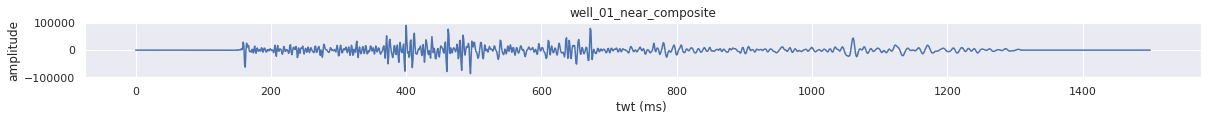

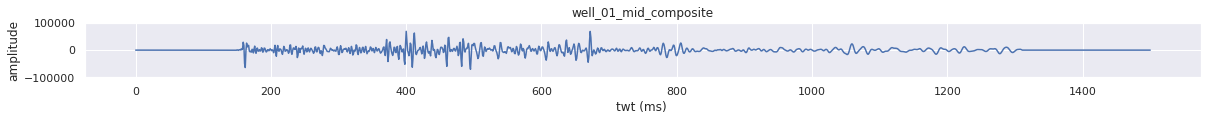

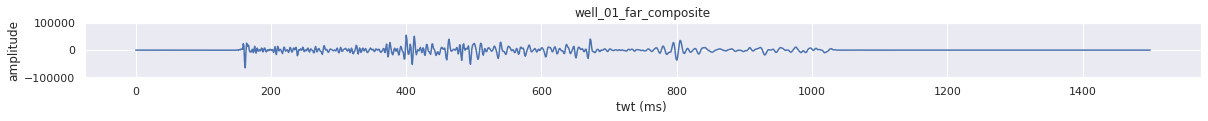

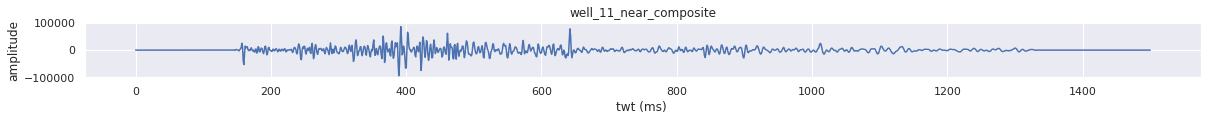

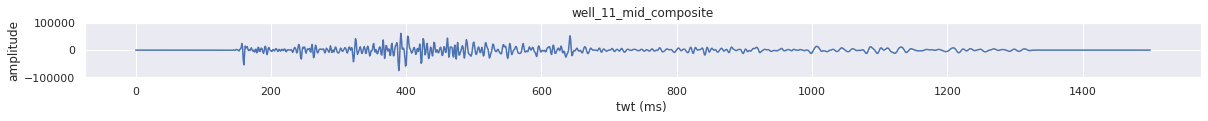

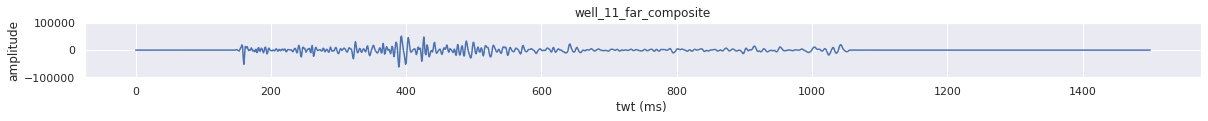

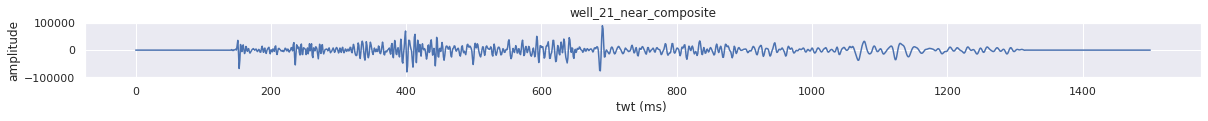

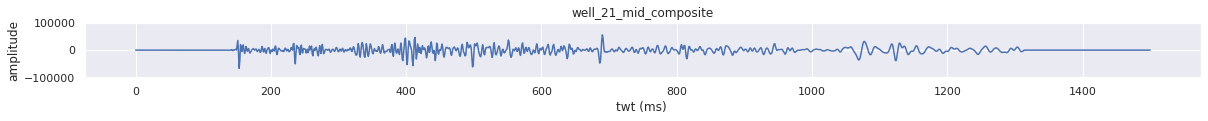

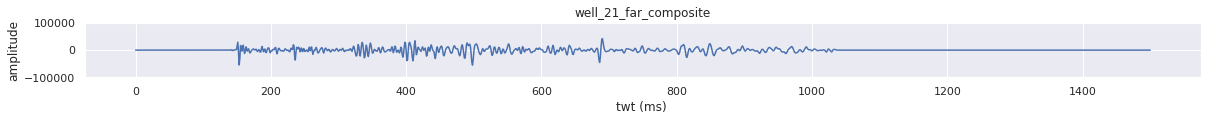

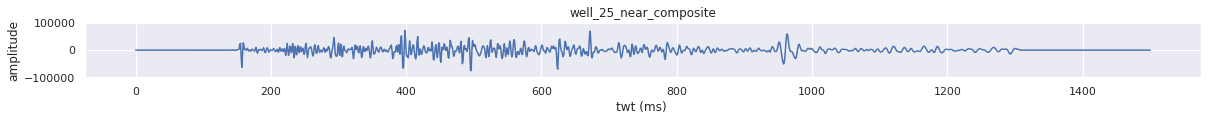

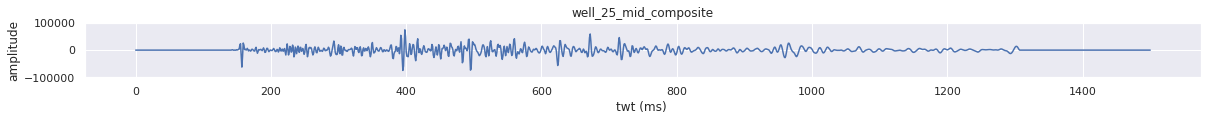

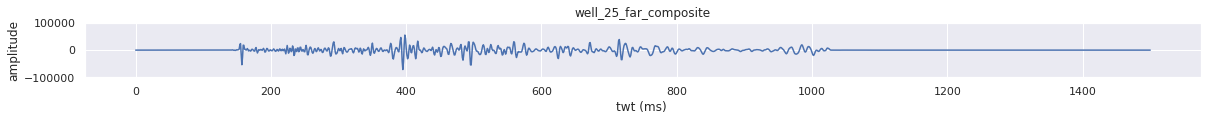

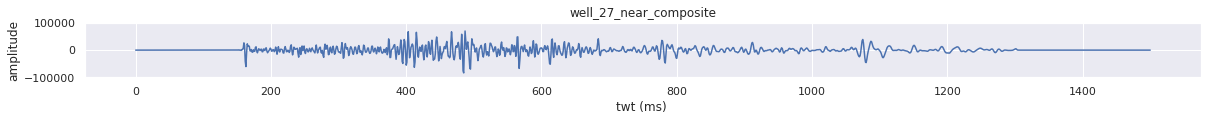

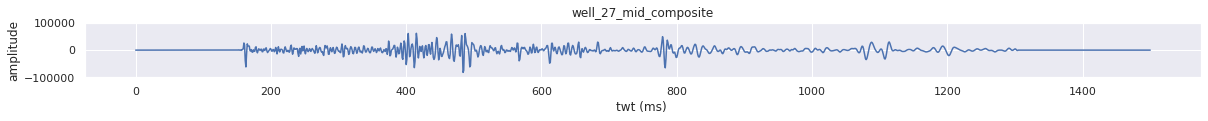

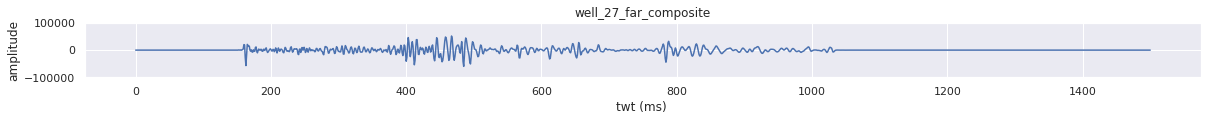

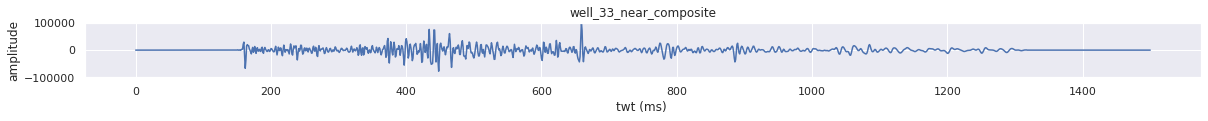

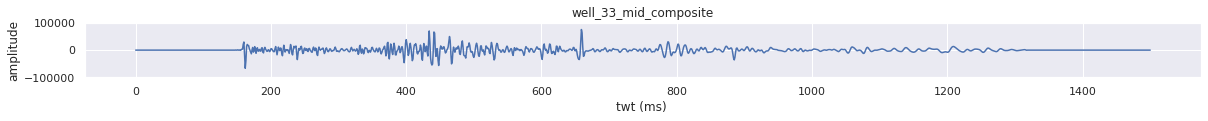

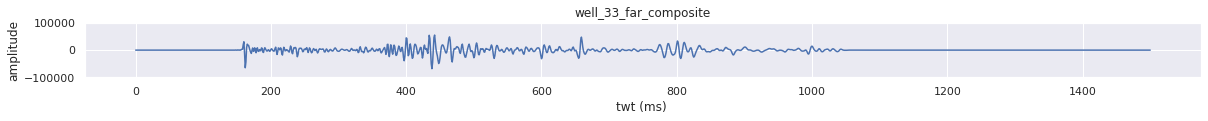

In [6]:
for composite in df:
    plt.figure(figsize=(20,1))
    plt.plot(df[composite])
    plt.title(composite)
    plt.ylim(-100000,100000)
    plt.xlabel('twt (ms) ')
    plt.ylabel('amplitude')

### Well Velocity composite

In [7]:
## Getting the well velocity composite
first_velocity = seismic_names[3]
print(first_velocity)
df_vel = pd.DataFrame(np.mean((np.mean(well_seismic['well_01'][first_velocity],axis=1)), axis=0),
                                        columns=['well_01_' + first_velocity + '_composite'])
for well in wells.keys():
        df_vel[well + '_' + first_velocity + '_composite'] = np.mean((np.mean(well_seismic[well][first_velocity],axis=1)), axis=0)

df_vel.head()

velocity


well_01_velocity_composite  well_11_velocity_composite  \
0                 1523.470219                 1523.452544   
1                 1523.470219                 1523.452544   
2                 1523.470219                 1523.452544   
3                 1523.470219                 1523.452544   
4                 1523.470219                 1523.452544   

   well_21_velocity_composite  well_25_velocity_composite  \
0                 1523.463996                 1523.462119   
1                 1523.463996                 1523.462119   
2                 1523.463996                 1523.462119   
3                 1523.463996                 1523.462119   
4                 1523.463996                 1523.462119   

   well_27_velocity_composite  well_33_velocity_composite  
0                 1523.447081                 1523.457274  
1                 1523.447081                 1523.457274  
2                 1523.447081                 1523.457274  
3                 1523.447081                 1523.457274  
4                 1523.447081                 1523.457274

Velocity composites QC 

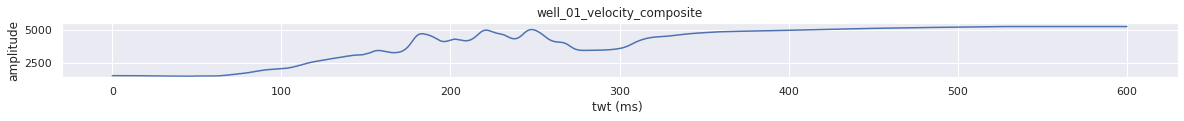

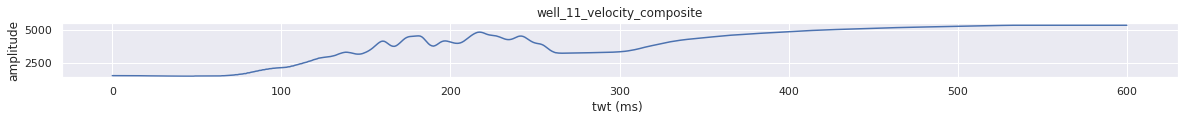

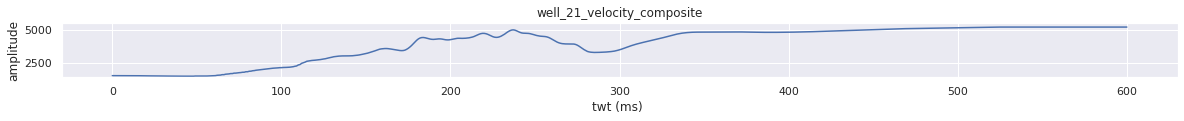

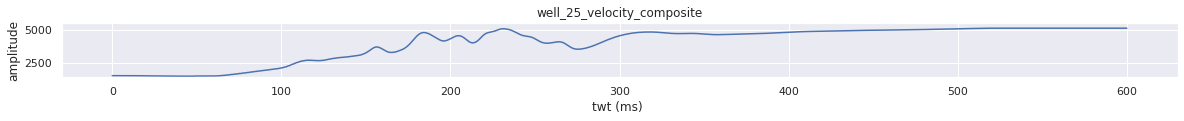

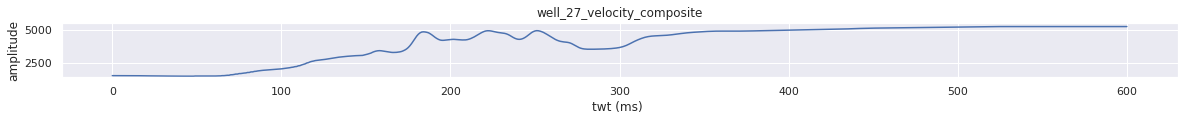

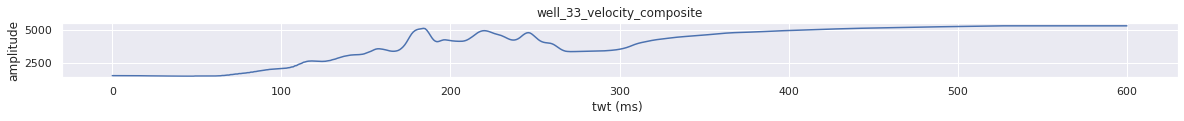

In [8]:
for composite in df_vel:
    plt.figure(figsize=(20,1))
    plt.plot(df_vel[composite])
    plt.title(composite)
    plt.ylim(1400,5500)
    plt.xlabel('twt (ms) ')
    plt.ylabel('amplitude')

Create the two-way-time indices for the training DataFrame.

We will interpolate seismic traces using `cubic` interpolation to the same sample rate as the well data, which is every 0.5 ms two-way-time.

If you recall:

*Poseidon data vertical sampling is between 0 and 6,000 milliseconds.*

*Seismic is sampled every 4 ms, and velocities are sampled every 10 ms.*



In [9]:
# index at 4ms 
seismic_twt = pd.DataFrame(np.arange(0, 6004.0, 4.0), columns=['twt'])

# index at .5 ms 
resamp_twt = pd.DataFrame(np.arange(0, 6000.5, 0.5), columns=['twt'])

# index at 10 ms 
velocity_twt = pd.DataFrame(np.arange(0, 6010.0, 10), columns=['twt'])

Merge in the acutal times

In [10]:
# Here we merge our seismic to the resamp 'twt' array
df['twt'] = seismic_twt
df_raw = df.merge(resamp_twt, how='right', on=['twt'])

# Here we interpolate the gaps in the seismic after the resamp
df_resamp_interp = df_raw.interpolate(method='cubic', limit_direction='forward', axis=0)

#let's look at the result
df_resamp_interp.head()

well_01_near_composite  well_01_mid_composite  well_01_far_composite  \
0               -2.459141              -2.177104              -1.195044   
1               -2.459141              -2.177104              -1.195044   
2               -2.459141              -2.177104              -1.195044   
3               -2.459141              -2.177104              -1.195044   
4               -2.459141              -2.177104              -1.195044   

   well_11_near_composite  well_11_mid_composite  well_11_far_composite  \
0               -0.359645               -3.05652              -1.788095   
1               -0.359645               -3.05652              -1.788095   
2               -0.359645               -3.05652              -1.788095   
3               -0.359645               -3.05652              -1.788095   
4               -0.359645               -3.05652              -1.788095   

   well_21_near_composite  well_21_mid_composite  well_21_far_composite  \
0               -3.358005              -1.519445               -1.54652   
1               -3.358005              -1.519445               -1.54652   
2               -3.358005              -1.519445               -1.54652   
3               -3.358005              -1.519445               -1.54652   
4               -3.358005              -1.519445               -1.54652   

   well_25_near_composite  well_25_mid_composite  well_25_far_composite  \
0               -1.516816              -2.399689              -1.273305   
1               -1.516816              -2.399689              -1.273305   
2               -1.516816              -2.399689              -1.273305   
3               -1.516816              -2.399689              -1.273305   
4               -1.516816              -2.399689              -1.273305   

   well_27_near_composite  well_27_mid_composite  well_27_far_composite  \
0               -1.597808              -1.749989              -0.613544   
1               -1.597808              -1.749989              -0.613544   
2               -1.597808              -1.749989              -0.613544   
3               -1.597808              -1.749989              -0.613544   
4               -1.597808              -1.749989              -0.613544   

   well_33_near_composite  well_33_mid_composite  well_33_far_composite  twt  
0               -1.578084              -1.144555               -1.94823  0.0  
1               -1.578084              -1.144555               -1.94823  0.5  
2               -1.578084              -1.144555               -1.94823  1.0  
3               -1.578084              -1.144555               -1.94823  1.5  
4               -1.578084              -1.144555               -1.94823  2.0

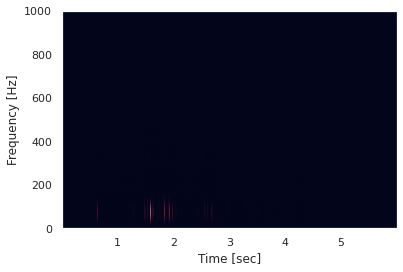

6000.0 (8193, 799) 8193 799


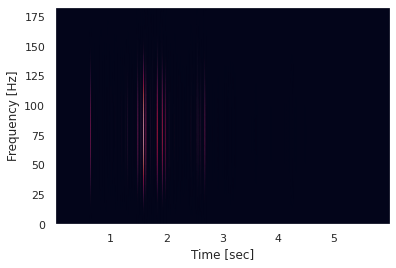

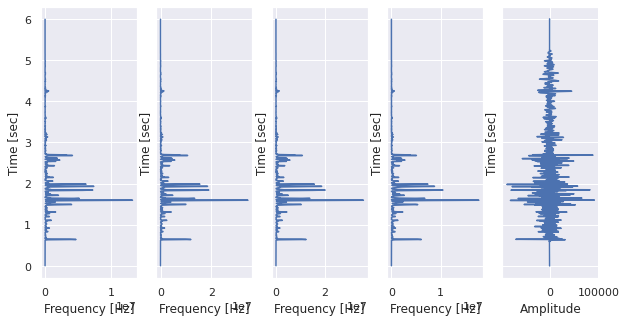

In [11]:
from scipy import signal
from scipy.fft import fftshift
fs = 20e2
N = 1e5
nfft=2**14
nperseg=20
noverlap=5
f, t, Sxx = signal.spectrogram(df_resamp_interp['well_01_near_composite'], fs, nperseg=nperseg, nfft=nfft, noverlap=noverlap)
plt.pcolormesh(t, f, Sxx, shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

print(np.max(df_resamp_interp['twt']) - np.min(df_resamp_interp['twt']), Sxx.shape, len(f), len(t))

plt.pcolormesh(t, f[:1501], Sxx[:1501,:], shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()


fig, ax = plt.subplots(1, 5, sharey='all',figsize=(10,5))
ax[0].plot(np.abs(Sxx[250:251,:]).flatten(), t)
ax[0].set_xlabel('Frequency [Hz]')
ax[0].set_ylabel('Time [sec]')
ax[1].plot(np.abs(Sxx[500:501,:]).flatten(), t)
ax[1].set_xlabel('Frequency [Hz]')
ax[1].set_ylabel('Time [sec]')
ax[2].plot(np.abs(Sxx[750:751,:]).flatten(), t)
ax[2].set_xlabel('Frequency [Hz]')
ax[2].set_ylabel('Time [sec]')
ax[3].plot(np.abs(Sxx[1000:1001,:]).flatten(), t)
ax[3].set_xlabel('Frequency [Hz]')
ax[3].set_ylabel('Time [sec]')
ax[4].plot(df_resamp_interp['well_01_near_composite'], df_resamp_interp['twt']/1000)
ax[4].set_xlabel('Amplitude')
ax[4].set_ylabel('Time [sec]')
plt.show()

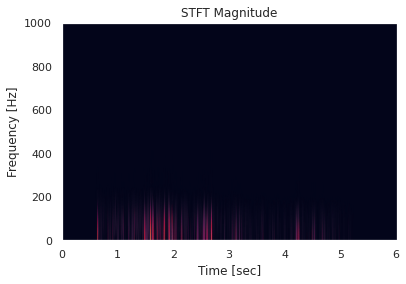

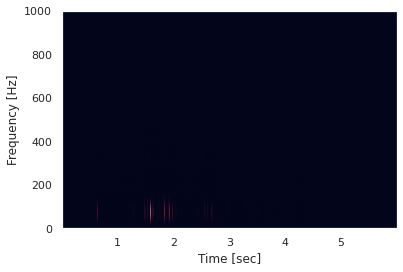

In [12]:

fZ, tZ, Zxx = signal.stft(df_resamp_interp['well_01_near_composite'], fs, nperseg=nperseg, nfft=nfft, noverlap=noverlap)
plt.pcolormesh(tZ, fZ, np.abs(Zxx), shading='gouraud')
plt.title('STFT Magnitude')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

f, t, Sxx = signal.spectrogram(df_resamp_interp['well_01_near_composite'], fs, nperseg=nperseg, nfft=nfft, noverlap=noverlap)
plt.pcolormesh(t, f, Sxx, shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


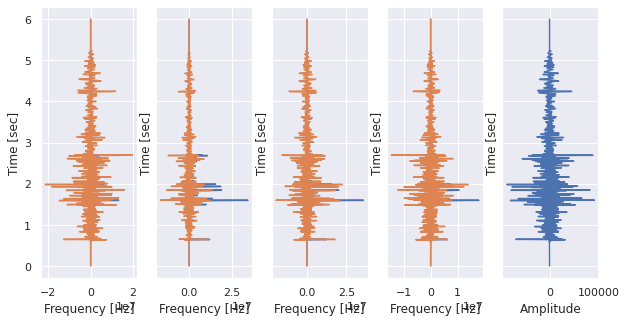

In [13]:

fig, ax = plt.subplots(1, 5, sharey='all',figsize=(10,5))
ax[0].plot(Sxx[250:251,:].flatten(), t)
ax[0].plot(Zxx[250:251,:].flatten()*500, tZ)
ax[0].set_xlabel('Frequency [Hz]')
ax[0].set_ylabel('Time [sec]')
ax[1].plot(Sxx[500:501,:].flatten(), t)
ax[1].plot(Zxx[500:501,:].flatten()*500, tZ)
ax[1].set_xlabel('Frequency [Hz]')
ax[1].set_ylabel('Time [sec]')
ax[2].plot(Sxx[750:751,:].flatten(), t)
ax[2].plot(Zxx[750:751,:].flatten()*500, tZ)
ax[2].set_xlabel('Frequency [Hz]')
ax[2].set_ylabel('Time [sec]')
ax[3].plot(Sxx[1000:1001,:].flatten(), t)
ax[3].plot(Zxx[1000:1001,:].flatten()*500, tZ)
ax[3].set_xlabel('Frequency [Hz]')
ax[3].set_ylabel('Time [sec]')
ax[4].plot(df_resamp_interp['well_01_near_composite'], df_resamp_interp['twt']/1000)
ax[4].set_xlabel('Amplitude')
ax[4].set_ylabel('Time [sec]')
plt.show()

In [14]:
df_resamp_interp.columns

Index(['well_01_near_composite', 'well_01_mid_composite',
       'well_01_far_composite', 'well_11_near_composite',
       'well_11_mid_composite', 'well_11_far_composite',
       'well_21_near_composite', 'well_21_mid_composite',
       'well_21_far_composite', 'well_25_near_composite',
       'well_25_mid_composite', 'well_25_far_composite',
       'well_27_near_composite', 'well_27_mid_composite',
       'well_27_far_composite', 'well_33_near_composite',
       'well_33_mid_composite', 'well_33_far_composite', 'twt'],
      dtype='object')

In [15]:
def get_specttime(data, fs, nperseg, nfft, noverlap, wname):
    
    f, t, Sxx = signal.spectrogram(data.values, fs, nperseg=nperseg, nfft=nfft, noverlap=noverlap)
    fZ, tZ, Zxx = signal.stft(data.values, fs, nperseg=nperseg, nfft=nfft, noverlap=noverlap)
    
    Sxx = np.abs(Sxx)
    Zxx = np.abs(Zxx)
    #if tadd == True:
    spectrogram_twt = pd.DataFrame(t*1000, columns=['twt'])
    stft_twt = pd.DataFrame(tZ*1000, columns=['twt'])
        
    df_spft = pd.DataFrame(Sxx[250:1001:250, :].T, columns=[wname+'_spft0', wname+'_spft1', wname+'_spft2', wname+'_spft3'])
    df_stft = pd.DataFrame(Zxx[250:1001:250, :].T, columns=[wname+'_stft0', wname+'_stft1', wname+'_stft2', wname+'_stft3'])
    
    df_spft = df_spft.join(spectrogram_twt, how='outer') #.merge(spectrogram_twt)
    df_stft = df_stft.join(stft_twt, how='outer') #.merge(stft_twt)
        
    df_spft_raw = df_spft.merge(resamp_twt, how='right', on=['twt'])
    df_stft_raw = df_stft.merge(resamp_twt, how='right', on=['twt'])

    # Here we interpolate the gaps in the seismic after the resamp
    df_spft_resamp_interp = df_spft_raw.interpolate(method='cubic', limit_direction='forward', axis=0)
    df_stft_resamp_interp = df_stft_raw.interpolate(method='cubic', limit_direction='forward', axis=0)
        
    return df_spft_resamp_interp, df_stft_resamp_interp

new_attributes_sp = []
new_attributes_st = []

for i in range(18):
    data = df_resamp_interp[df_resamp_interp.columns[i]]
    #if i < 17:
    df_spft_temp, df_stft_temp = get_specttime(data, fs, nperseg, nfft, noverlap, df_resamp_interp.columns[i])
    #else:
    #df_spft_temp, df_stft_temp = get_specttime(data, fs, nperseg, nfft, noverlap, True, df_resamp_interp.columns[i])
        
    new_attributes_sp.append(df_spft_temp)
    new_attributes_st.append(df_stft_temp)
    
df_sp = reduce(lambda x, y: pd.merge(x, y, on='twt'), new_attributes_sp)
df_st = reduce(lambda x, y: pd.merge(x, y, on='twt'), new_attributes_st)

print(df_st.columns)
df_st.head()

Index(['well_01_near_composite_stft0', 'well_01_near_composite_stft1',
       'well_01_near_composite_stft2', 'well_01_near_composite_stft3', 'twt',
       'well_01_mid_composite_stft0', 'well_01_mid_composite_stft1',
       'well_01_mid_composite_stft2', 'well_01_mid_composite_stft3',
       'well_01_far_composite_stft0', 'well_01_far_composite_stft1',
       'well_01_far_composite_stft2', 'well_01_far_composite_stft3',
       'well_11_near_composite_stft0', 'well_11_near_composite_stft1',
       'well_11_near_composite_stft2', 'well_11_near_composite_stft3',
       'well_11_mid_composite_stft0', 'well_11_mid_composite_stft1',
       'well_11_mid_composite_stft2', 'well_11_mid_composite_stft3',
       'well_11_far_composite_stft0', 'well_11_far_composite_stft1',
       'well_11_far_composite_stft2', 'well_11_far_composite_stft3',
       'well_21_near_composite_stft0', 'well_21_near_composite_stft1',
       'well_21_near_composite_stft2', 'well_21_near_composite_stft3',
       'well_21

well_01_near_composite_stft0  well_01_near_composite_stft1  \
0                      1.323855                      1.240937   
1                      1.394666                      1.289620   
2                      1.462148                      1.336014   
3                      1.526379                      1.380173   
4                      1.587437                      1.422150   

   well_01_near_composite_stft2  well_01_near_composite_stft3  twt  \
0                      1.112705                      0.952904  0.0   
1                      1.132220                      0.944564  0.5   
2                      1.150818                      0.936616  1.0   
3                      1.168520                      0.929051  1.5   
4                      1.185348                      0.921860  2.0   

   well_01_mid_composite_stft0  well_01_mid_composite_stft1  \
0                     1.172024                     1.098615   
1                     1.234713                     1.141715   
2                     1.294456                     1.182788   
3                     1.351320                     1.221882   
4                     1.405375                     1.259045   

   well_01_mid_composite_stft2  well_01_mid_composite_stft3  \
0                     0.985090                     0.843616   
1                     1.002367                     0.836233   
2                     1.018832                     0.829196   
3                     1.034504                     0.822499   
4                     1.049401                     0.816132   

   well_01_far_composite_stft0  ...  well_33_near_composite_stft2  \
0                     0.643341  ...                      0.714047   
1                     0.677752  ...                      0.726570   
2                     0.710545  ...                      0.738505   
3                     0.741759  ...                      0.749865   
4                     0.771431  ...                      0.760663   

   well_33_near_composite_stft3  well_33_mid_composite_stft0  \
0                      0.611499                     0.616161   
1                      0.606147                     0.649118   
2                      0.601047                     0.680526   
3                      0.596192                     0.710421   
4                      0.591577                     0.738839   

   well_33_mid_composite_stft1  well_33_mid_composite_stft2  \
0                     0.577568                     0.517885   
1                     0.600226                     0.526968   
2                     0.621820                     0.535624   
3                     0.642373                     0.543863   
4                     0.661910                     0.551695   

   well_33_mid_composite_stft3  well_33_far_composite_stft0  \
0                     0.443509                     1.048811   
1                     0.439627                     1.104910   
2                     0.435928                     1.158372   
3                     0.432407                     1.209259   
4                     0.429060                     1.257631   

   well_33_far_composite_stft1  well_33_far_composite_stft2  \
0                     0.983120                     0.881529   
1                     1.021689                     0.896990   
2                     1.058444                     0.911724   
3                     1.093428                     0.925749   
4                     1.126684                     0.939080   

   well_33_far_composite_stft3  
0                     0.754928  
1                     0.748321  
2                     0.742025  
3                     0.736031  
4                     0.730334  

[5 rows x 73 columns]

In [16]:
# Here we merge our seismic to the resamp 'twt' array
df_vel['twt'] = velocity_twt
df_raw_vel = df_vel.merge(resamp_twt, how='right', on=['twt'])

# Here we interpolate the gaps in the seismic after the resamp
df_resamp_vel_interp = df_raw_vel.interpolate(method='cubic', limit_direction='forward', axis=0)

#let's look at the result
df_resamp_vel_interp.head()

well_01_velocity_composite  well_11_velocity_composite  \
0                 1523.470219                 1523.452544   
1                 1523.470526                 1523.452804   
2                 1523.470786                 1523.453025   
3                 1523.471001                 1523.453208   
4                 1523.471174                 1523.453355   

   well_21_velocity_composite  well_25_velocity_composite  \
0                 1523.463996                 1523.462119   
1                 1523.464278                 1523.462399   
2                 1523.464516                 1523.462637   
3                 1523.464714                 1523.462833   
4                 1523.464872                 1523.462991   

   well_27_velocity_composite  well_33_velocity_composite  twt  
0                 1523.447081                 1523.457274  0.0  
1                 1523.447341                 1523.457536  0.5  
2                 1523.447561                 1523.457757  1.0  
3                 1523.447743                 1523.457940  1.5  
4                 1523.447889                 1523.458087  2.0

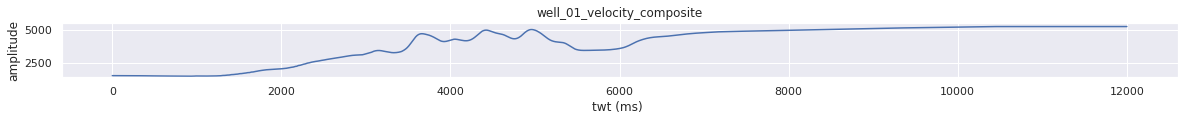

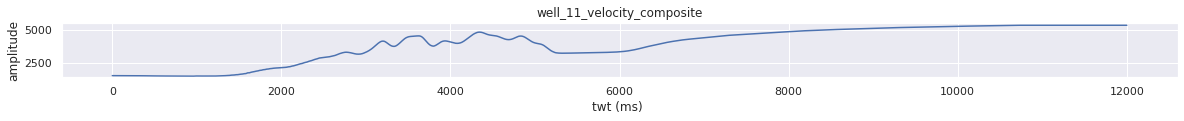

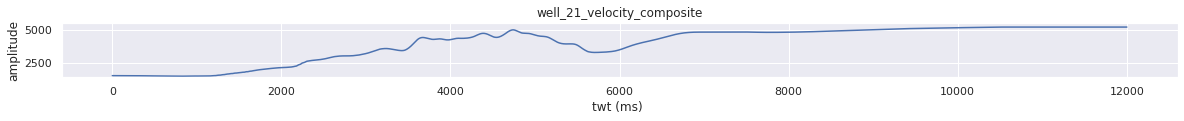

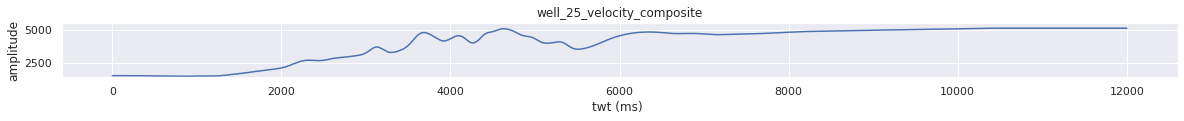

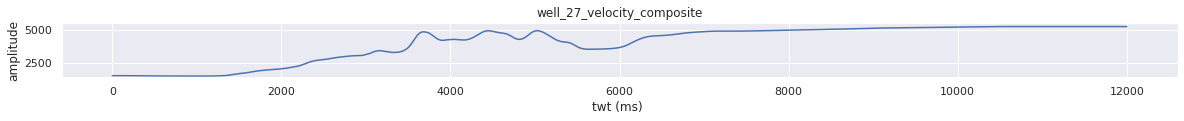

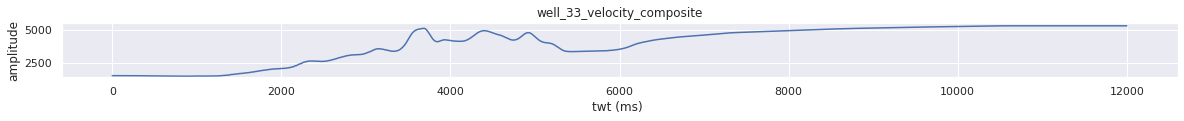

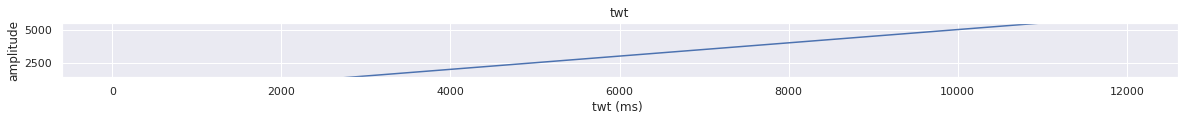

In [17]:
for composite in df_resamp_vel_interp:
    plt.figure(figsize=(20,1))
    plt.plot(df_resamp_vel_interp[composite])
    plt.title(composite)
    plt.ylim(1400,5500)
    plt.xlabel('twt (ms) ')
    plt.ylabel('amplitude')

The new data frames are "df_resamp_vel_interp" for the well velocity resampled and the "df_resamp_interp" the well seismic resampled

In [18]:
## Save the new data frames 

dfvel_main = df_resamp_vel_interp.copy()
dfseismic_main = df_resamp_interp.copy()

In [19]:
#df_resamp_vel_interp = df_resamp_vel_interp.reset_index()
#df_resamp_interp = df_resamp_interp.reset_index()

### Wells!

In [20]:
 well_df.head()

tvdss     inline      xline   gamma   rshal   rdeep  nphi  \
well_id twt                                                                     
well_01 1136.5  2798.4675  2992.8834  2202.6259  8.6726  3.7827  2.2789   NaN   
        1137.0  2798.4723  2992.8834  2202.6259  8.6323  3.7982  2.2860   NaN   
        1137.5  2798.4771  2992.8834  2202.6258  8.5921  3.8136  2.2931   NaN   
        1138.0  2798.4819  2992.8834  2202.6258  8.5518  3.8290  2.3002   NaN   
        1138.5  2798.4867  2992.8834  2202.6258  8.5115  3.8445  2.3073   NaN   

                cal  rhob      dtc  dts  
well_id twt                              
well_01 1136.5  NaN   NaN  58.3867  NaN  
        1137.0  NaN   NaN  58.4215  NaN  
        1137.5  NaN   NaN  58.4564  NaN  
        1138.0  NaN   NaN  58.4912  NaN  
        1138.5  NaN   NaN  58.5260  NaN

Fit the logs to inflin the NANs

For DTS

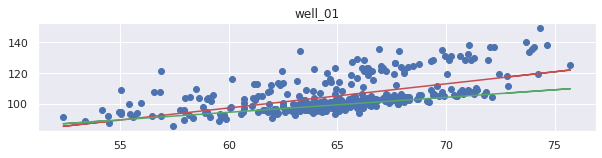

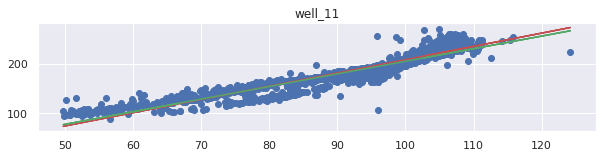

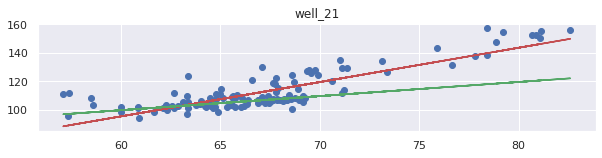

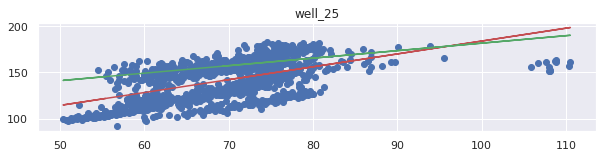

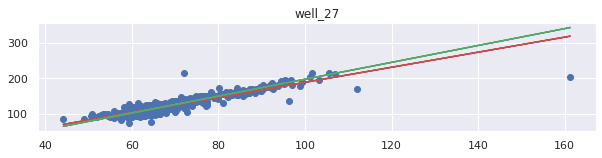

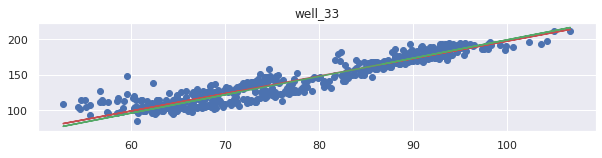

In [21]:
well_df['dts_calw'] = 0*well_df['dtc']
well_df['dts_calw_r'] = 0*well_df['dtc']

### Linear regression and its robust one dtc vs dts - individual wells
ransac = RANSACRegressor()
lmodel = LinearRegression(fit_intercept=True)

for well in well_df.index.levels[0]:
    fig, ax = plt.subplots(1, 1, sharey='all',figsize=(10,2))
    tmp_well = well_df.loc[well][['dtc', 'dts']]
    curves = tmp_well[['dtc', 'dts']].dropna()
    slope, intercept, r_value, p_value, std_err = stats.linregress(curves['dtc'],curves['dts'])
    
    tmp = well_df.loc[well]
    tmpp = tmp['dtc']
    dtc_arr = np.reshape(curves['dtc'].values, (len(curves['dtc'].values), 1))
    lmodel.fit(dtc_arr, curves['dts'].values)
    ransac.fit(dtc_arr, curves['dts'].values)
    
    well_df.loc[well]['dts_calw'] = slope*tmpp + intercept
    well_df.loc[well]['dts_calw_r'] = ransac.estimator_.coef_[0]*tmpp + ransac.estimator_.intercept_
    
    line_X = dtc_arr
    line_y = lmodel.predict(line_X)
    line_y_ransac = ransac.predict(line_X)

    #ax.figure(figsize=(2,10))
    ax.scatter(line_X, curves['dts'].values)
    ax.plot(line_X, line_y, 'r');
    ax.plot(line_X, line_y_ransac, 'g');
    plt.title(well)
    
    plt.show()

For RHOB

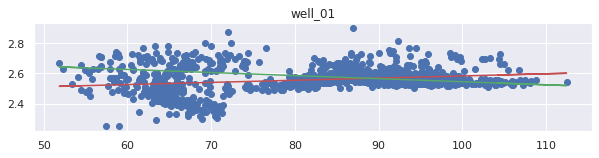

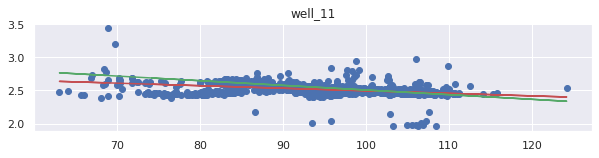

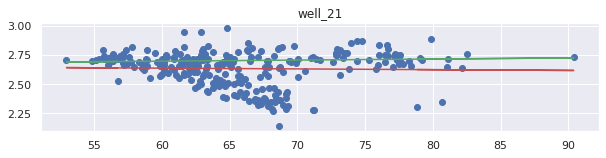

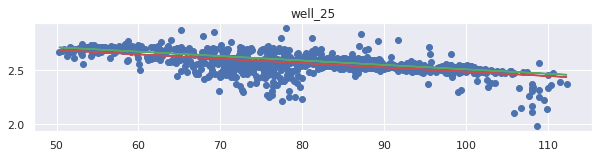

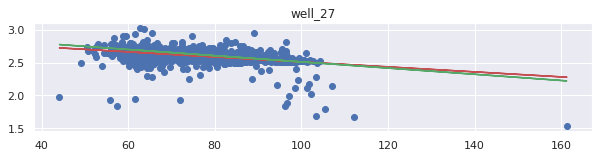

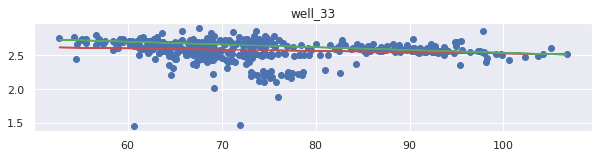

In [22]:
### Linear regression and its robust one dtc vs rhos - individual wells
ransac = RANSACRegressor()
lmodel = LinearRegression(fit_intercept=True)

well_df['rhob_calw'] = 0*well_df['dtc']
well_df['rhob_calw_r'] = 0*well_df['dtc']
for well in well_df.index.levels[0]:
    fig, ax = plt.subplots(1, 1, sharey='all',figsize=(10,2))
    tmp_well = well_df.loc[well][['dtc', 'rhob']]
    curves = tmp_well[['dtc', 'rhob']].dropna()
    slope, intercept, r_value, p_value, std_err = stats.linregress(curves['dtc'],curves['rhob'])
    
    dtc_arr = np.reshape(curves['dtc'].values, (len(curves['dtc'].values), 1))
    lmodel.fit(dtc_arr, curves['rhob'].values)
    ransac.fit(dtc_arr, curves['rhob'].values)
    well_df.loc[well]['rhob_calw'] = slope*well_df.loc[well]['dtc'] + intercept
    well_df.loc[well]['rhob_calw_r'] = ransac.estimator_.coef_*well_df.loc[well]['dtc'] + ransac.estimator_.intercept_
    
    line_X = dtc_arr
    line_y = lmodel.predict(line_X)
    line_y_ransac = ransac.predict(line_X)

    #ax.figure(figsize=(2,10))
    ax.scatter(line_X, curves['rhob'].values)
    ax.plot(line_X, line_y, 'r');
    ax.plot(line_X, line_y_ransac, 'g');
    plt.title(well)
    
    plt.show()

In [23]:
well_df['dts_new'] = well_df.dts
well_df['rhob_new'] = well_df.rhob

# Replace nans in dts from pseudo dts
well_df.dts_new.fillna(well_df.dts_calw, inplace=True)
well_df.rhob_new.fillna(well_df.rhob_calw_r, inplace=True)

## Impedance
well_df['imp_dtc_new'] = 1000000*well_df['rhob_new']/well_df['dtc']
well_df['imp_dts_new'] = 1000000*well_df['rhob_new']/well_df['dts_new']

## Impedance - log
well_df['imp_dtc_new_log'] = np.log(1000000*well_df['rhob_new']/well_df['dtc'])
well_df['imp_dts_new_log'] = np.log(1000000*well_df['rhob_new']/well_df['dts_new'])
well_df['rhob_new_log'] = np.log(well_df['rhob_new'])

In [24]:
well_df.head()

tvdss     inline      xline   gamma   rshal   rdeep  nphi  \
well_id twt                                                                     
well_01 1136.5  2798.4675  2992.8834  2202.6259  8.6726  3.7827  2.2789   NaN   
        1137.0  2798.4723  2992.8834  2202.6259  8.6323  3.7982  2.2860   NaN   
        1137.5  2798.4771  2992.8834  2202.6258  8.5921  3.8136  2.2931   NaN   
        1138.0  2798.4819  2992.8834  2202.6258  8.5518  3.8290  2.3002   NaN   
        1138.5  2798.4867  2992.8834  2202.6258  8.5115  3.8445  2.3073   NaN   

                cal  rhob      dtc  ...  dts_calw_r  rhob_calw  rhob_calw_r  \
well_id twt                         ...                                       
well_01 1136.5  NaN   NaN  58.3867  ...   92.932378   2.524116     2.629538   
        1137.0  NaN   NaN  58.4215  ...   92.966369   2.524166     2.629468   
        1137.5  NaN   NaN  58.4564  ...   93.000457   2.524215     2.629397   
        1138.0  NaN   NaN  58.4912  ...   93.034448   2.524265     2.629326   
        1138.5  NaN   NaN  58.5260  ...   93.068439   2.524314     2.629256   

                  dts_new  rhob_new   imp_dtc_new   imp_dts_new  \
well_id twt                                                       
well_01 1136.5  94.813819  2.629538  45036.598150  27733.703420   
        1137.0  94.868471  2.629468  45008.561927  27716.981962   
        1137.5  94.923280  2.629397  44980.478664  27700.231792   
        1138.0  94.977932  2.629326  44952.509237  27683.548866   
        1138.5  95.032583  2.629256  44924.573073  27666.885127   

                imp_dtc_new_log  imp_dts_new_log  rhob_new_log  
well_id twt                                                     
well_01 1136.5        10.715231        10.230404      0.966808  
        1137.0        10.714608        10.229801      0.966781  
        1137.5        10.713984        10.229196      0.966754  
        1138.0        10.713362        10.228594      0.966728  
        1138.5        10.712740        10.227991      0.966701  

[5 rows x 22 columns]

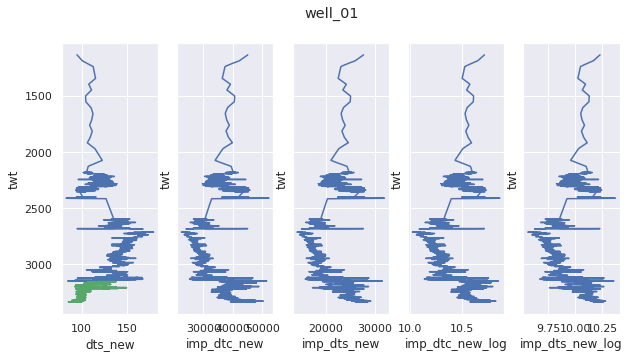

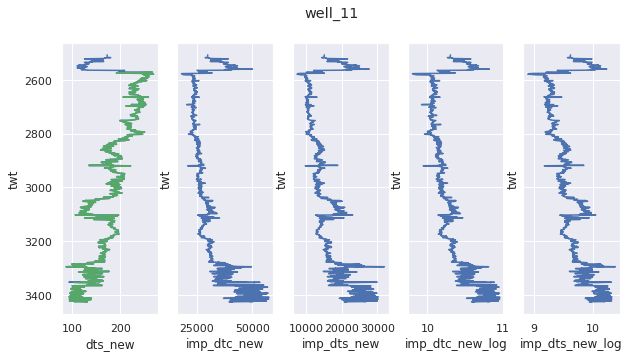

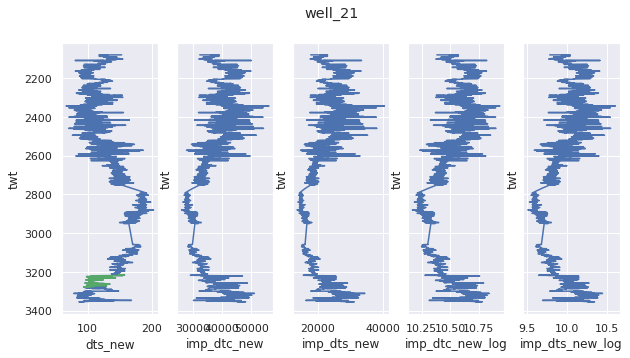

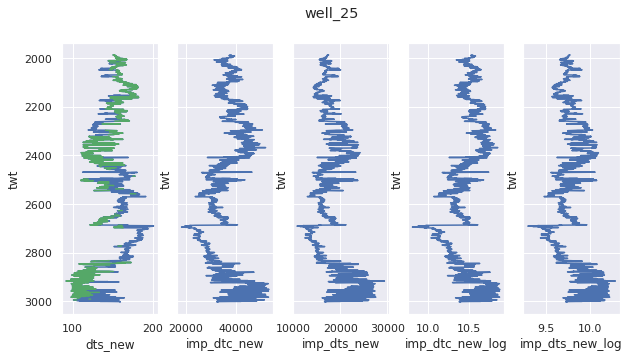

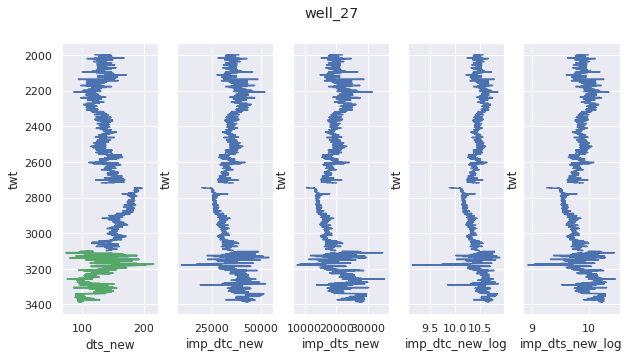

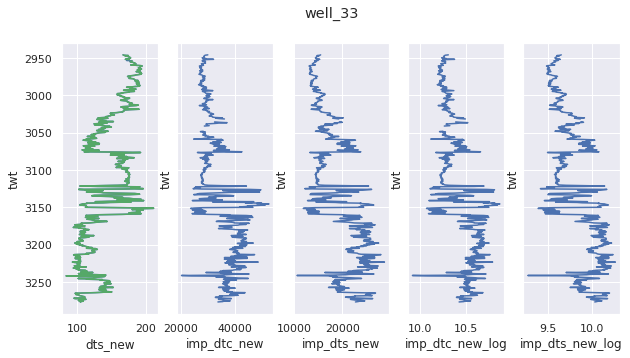

In [25]:
## For dts
for well in well_df.index.levels[0]:
    fig, ax = plt.subplots(1, 5, sharey='all',figsize=(10,5))
    curves = well_df.loc[well][['dts', 'dts_new', 'imp_dtc_new', 'imp_dts_new', 'imp_dtc_new_log', 'imp_dts_new_log']]
    fig.suptitle(well)
    #for idx, curve in enumerate(curves.columns):
    ax[0].plot(curves['dts_new'], curves['dts_new'].index, 'b')
    ax[0].plot(curves['dts'], curves['dts'].index, 'g')
    ax[0].set_ylabel(curves['dts_new'].index.name)
    ax[0].set_xlabel(curves['dts_new'].name)
    
    ax[1].plot(curves['imp_dtc_new'], curves['imp_dtc_new'].index, 'b')
    ax[1].set_ylabel(curves['imp_dtc_new'].index.name)
    ax[1].set_xlabel(curves['imp_dtc_new'].name)
    
    ax[2].plot(curves['imp_dts_new'], curves['imp_dts_new'].index, 'b')
    ax[2].set_ylabel(curves['imp_dts_new'].index.name)
    ax[2].set_xlabel(curves['imp_dts_new'].name)
    
    
    ax[3].plot(curves['imp_dtc_new_log'], curves['imp_dtc_new_log'].index, 'b')
    ax[3].set_ylabel(curves['imp_dtc_new_log'].index.name)
    ax[3].set_xlabel(curves['imp_dtc_new_log'].name)
    
    ax[4].plot(curves['imp_dts_new_log'], curves['imp_dts_new_log'].index, 'b')
    ax[4].set_ylabel(curves['imp_dts_new_log'].index.name)
    ax[4].set_xlabel(curves['imp_dts_new_log'].name)
    
    ax[0].invert_yaxis()

In [26]:
# Lets filter the well data and keep only the relevant columns
well_df_stripped = well_df[['imp_dtc_new', 'imp_dts_new', 'imp_dtc_new_log', 'imp_dts_new_log', 'rhob_new', 'rhob_new_log']]

Now we need to merge these two on the twt column - this gives us the association in twt of the well data and the composite trace. This is were good well-ties plays the most important role. 

In [27]:
df_sp.head()

well_01_near_composite_spft0  well_01_near_composite_spft1  \
0                           NaN                           NaN   
1                           NaN                           NaN   
2                           NaN                           NaN   
3                           NaN                           NaN   
4                           NaN                           NaN   

   well_01_near_composite_spft2  well_01_near_composite_spft3  twt  \
0                           NaN                           NaN  0.0   
1                           NaN                           NaN  0.5   
2                           NaN                           NaN  1.0   
3                           NaN                           NaN  1.5   
4                           NaN                           NaN  2.0   

   well_01_mid_composite_spft0  well_01_mid_composite_spft1  \
0                          NaN                          NaN   
1                          NaN                          NaN   
2                          NaN                          NaN   
3                          NaN                          NaN   
4                          NaN                          NaN   

   well_01_mid_composite_spft2  well_01_mid_composite_spft3  \
0                          NaN                          NaN   
1                          NaN                          NaN   
2                          NaN                          NaN   
3                          NaN                          NaN   
4                          NaN                          NaN   

   well_01_far_composite_spft0  ...  well_33_near_composite_spft2  \
0                          NaN  ...                           NaN   
1                          NaN  ...                           NaN   
2                          NaN  ...                           NaN   
3                          NaN  ...                           NaN   
4                          NaN  ...                           NaN   

   well_33_near_composite_spft3  well_33_mid_composite_spft0  \
0                           NaN                          NaN   
1                           NaN                          NaN   
2                           NaN                          NaN   
3                           NaN                          NaN   
4                           NaN                          NaN   

   well_33_mid_composite_spft1  well_33_mid_composite_spft2  \
0                          NaN                          NaN   
1                          NaN                          NaN   
2                          NaN                          NaN   
3                          NaN                          NaN   
4                          NaN                          NaN   

   well_33_mid_composite_spft3  well_33_far_composite_spft0  \
0                          NaN                          NaN   
1                          NaN                          NaN   
2                          NaN                          NaN   
3                          NaN                          NaN   
4                          NaN                          NaN   

   well_33_far_composite_spft1  well_33_far_composite_spft2  \
0                          NaN                          NaN   
1                          NaN                          NaN   
2                          NaN                          NaN   
3                          NaN                          NaN   
4                          NaN                          NaN   

   well_33_far_composite_spft3  
0                          NaN  
1                          NaN  
2                          NaN  
3                          NaN  
4                          NaN  

[5 rows x 73 columns]

In [28]:
tt_independent_wells = []
df_resamp_interp_new = df_resamp_interp.merge(df_sp, on='twt')
df_resamp_interp_new = df_resamp_interp_new.merge(df_st, on='twt')

for well in well_df.index.levels[0]:
    
    for seismic_name in seismic_names_just:
        df_seis_temp = df_resamp_interp_new[[well + '_' + seismic_name + '_composite','twt',well + '_' + seismic_name + '_composite_stft0',
                                        well + '_' + seismic_name + '_composite_stft1', well + '_' + seismic_name + '_composite_stft2',
                                        well + '_' + seismic_name + '_composite_stft3',well + '_' + seismic_name + '_composite_spft0',
                                        well + '_' + seismic_name + '_composite_spft1', well + '_' + seismic_name + '_composite_spft2',
                                        well + '_' + seismic_name + '_composite_spft3']]
        well_reset = well_df_stripped.loc[well]
        well_reset.reset_index(level=0, inplace=True)
        well_temp_tt = well_reset.merge(df_seis_temp, how='right', on=['twt'])
        well_temp_tt['well_name'] = [well] * len(well_temp_tt)
        well_temp_tt.set_index(['well_name'], inplace=True)
        well_temp_tt.rename(columns={well + '_' + seismic_name + '_composite': "composite_trace"}, inplace=True)
        well_temp_tt.rename(columns={well + '_' + seismic_name + '_composite_stft0': "composite_trace_stft0"}, inplace=True)
        well_temp_tt.rename(columns={well + '_' + seismic_name + '_composite_stft1': "composite_trace_stft1"}, inplace=True)
        well_temp_tt.rename(columns={well + '_' + seismic_name + '_composite_stft2': "composite_trace_stft2"}, inplace=True)
        well_temp_tt.rename(columns={well + '_' + seismic_name + '_composite_stft3': "composite_trace_stft3"}, inplace=True)
        well_temp_tt.rename(columns={well + '_' + seismic_name + '_composite_spft0': "composite_trace_spft0"}, inplace=True)
        well_temp_tt.rename(columns={well + '_' + seismic_name + '_composite_spft1': "composite_trace_spft1"}, inplace=True)
        well_temp_tt.rename(columns={well + '_' + seismic_name + '_composite_spft2': "composite_trace_spft2"}, inplace=True)
        well_temp_tt.rename(columns={well + '_' + seismic_name + '_composite_spft3': "composite_trace_spft3"}, inplace=True)
        
        
        tt_independent_wells.append(well_temp_tt)

#tt_independent_wells
well_temp_tt.head()

well_temp_tt.describe()

twt   imp_dtc_new   imp_dts_new  imp_dtc_new_log  \
count  12001.000000    643.000000    658.000000       643.000000   
mean    3000.000000  33622.635621  18629.925707        10.407374   
std     1732.267312   6067.380872   4321.329558         0.174966   
min        0.000000  20231.575436  10585.339069         9.915000   
25%     1500.000000  28477.859546  14738.370965        10.256882   
50%     3000.000000  31597.018771  17434.712822        10.360818   
75%     4500.000000  38524.356405  22515.238344        10.559046   
max     6000.000000  52354.024672  28782.465449        10.865784   

       imp_dts_new_log    rhob_new  rhob_new_log  composite_trace  \
count       658.000000  730.000000    730.000000     12001.000000   
mean          9.806312    2.563887      0.939863        -2.077212   
std           0.227845    0.139625      0.059562      9081.308309   
min           9.267225    1.442600      0.366447    -68331.737849   
25%           9.598210    2.525825      0.926568      -928.626943   
50%           9.766218    2.579370      0.947545        -1.948230   
75%          10.021947    2.635350      0.969016      1309.279171   
max          10.267522    2.915000      1.069870     56929.861262   

       composite_trace_stft0  composite_trace_stft1  composite_trace_stft2  \
count           12001.000000           12001.000000           12001.000000   
mean             4032.204034            3549.355667            2814.078387   
std              7124.978586            6094.273026            4683.665035   
min             -4289.139347           -3278.637458           -2620.255308   
25%                 1.833999               1.522938               1.097927   
50%              1095.271572            1101.469288             971.897780   
75%              5021.872082            4450.271293            3584.921552   
max             61495.199755           51493.262170           38318.554841   

       composite_trace_stft3  composite_trace_spft0  composite_trace_spft1  \
count           12001.000000           1.197100e+04           1.197100e+04   
mean             1971.453041           6.414024e+04           1.592575e+05   
std              3192.899914           2.428666e+05           6.071799e+05   
min             -1961.993890          -1.266527e+05          -3.564280e+05   
25%                 0.662451           2.647187e-25           6.934370e-26   
50%               749.504124           8.376285e+02           1.996279e+03   
75%              2545.478277           2.570892e+04           6.295960e+04   
max             24873.202456           3.618040e+06           8.982905e+06   

       composite_trace_spft2  composite_trace_spft3  
count           1.197100e+04           1.197100e+04  
mean            1.631066e+05           8.058898e+04  
std             6.124888e+05           2.914718e+05  
min            -2.900408e+05          -1.249678e+05  
25%             2.140959e-22           3.657114e-16  
50%             2.283839e+03           1.411637e+03  
75%             6.532245e+04           3.339281e+04  
max             8.845492e+06           3.959840e+06

Let's take a look at what our data looks like right now. You will notice that we don't have much data for the shallow or deep sections. Most of our data is between 2500ms and 3500ms. Your final, evaluation will likely focus on this interval. 

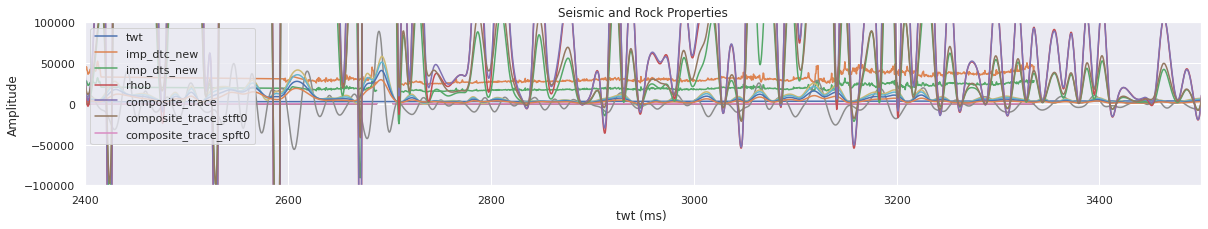

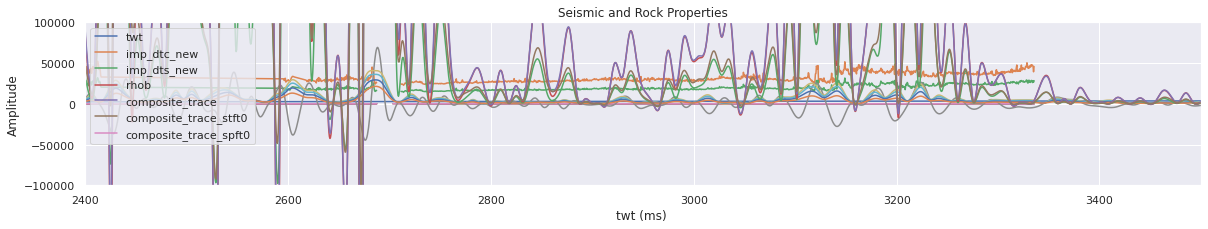

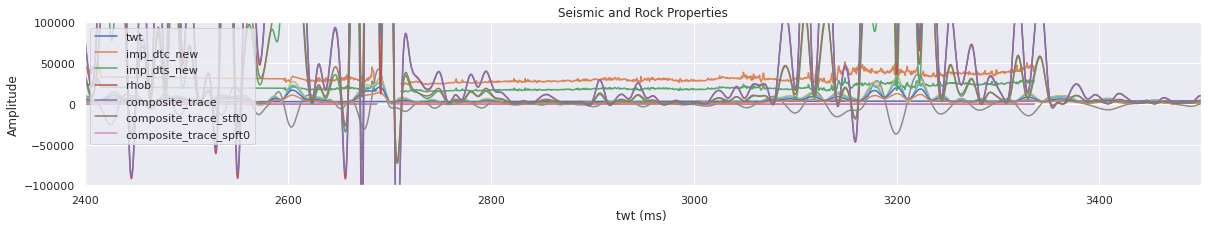

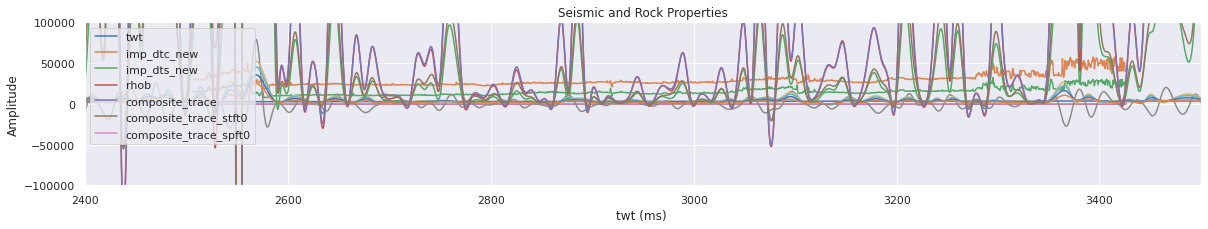

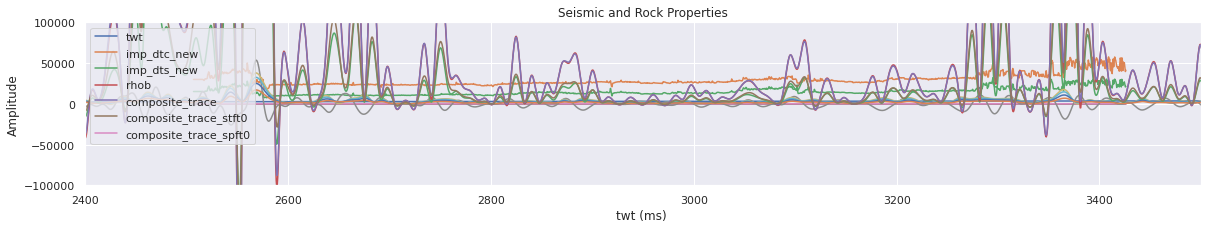

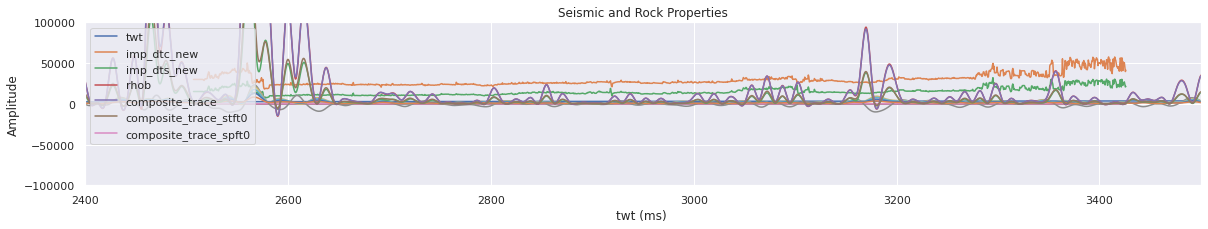

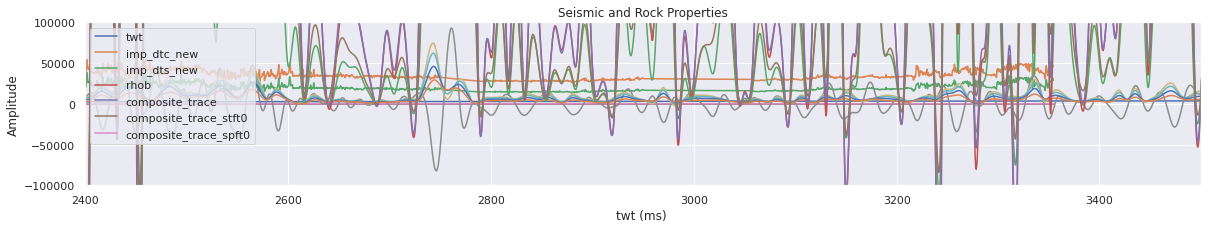

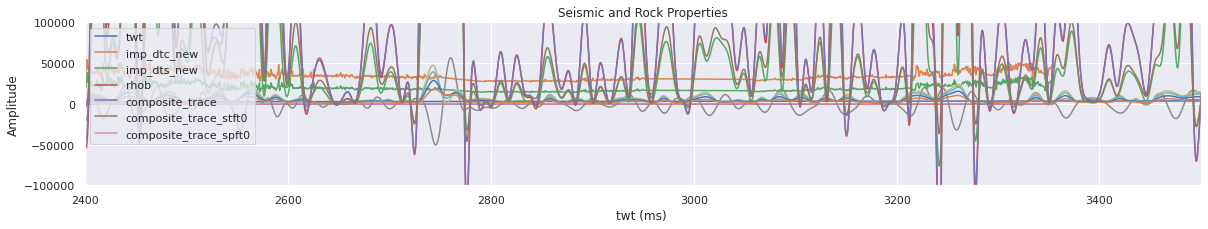

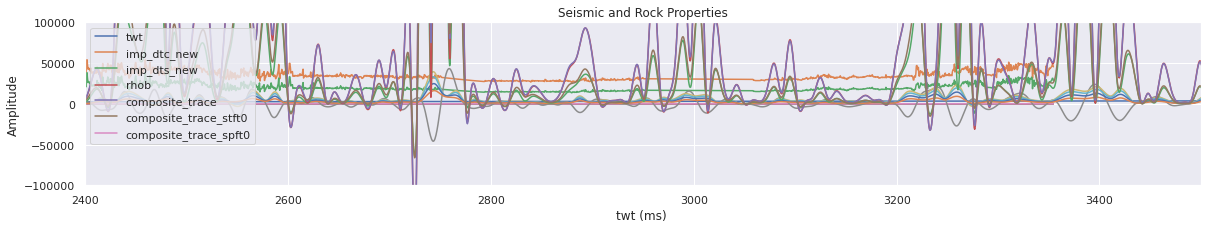

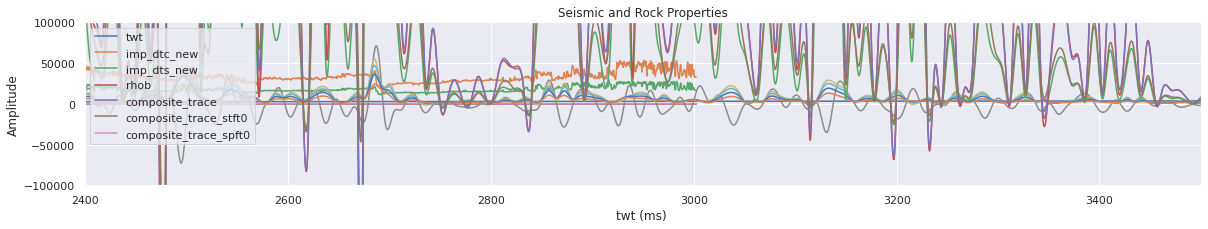

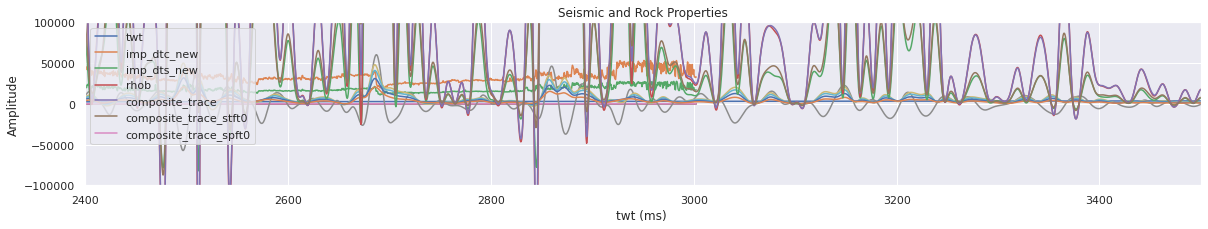

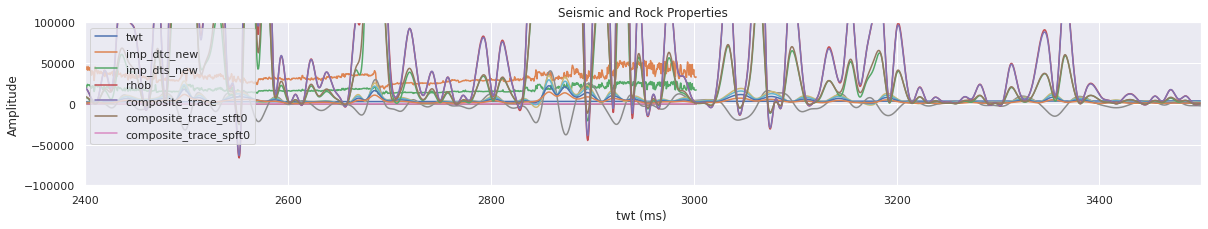

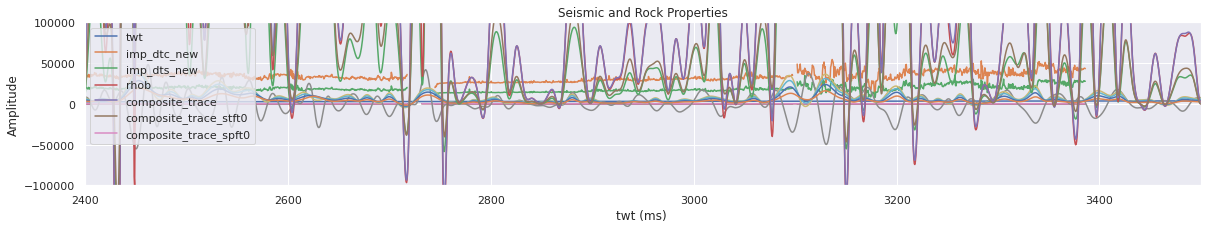

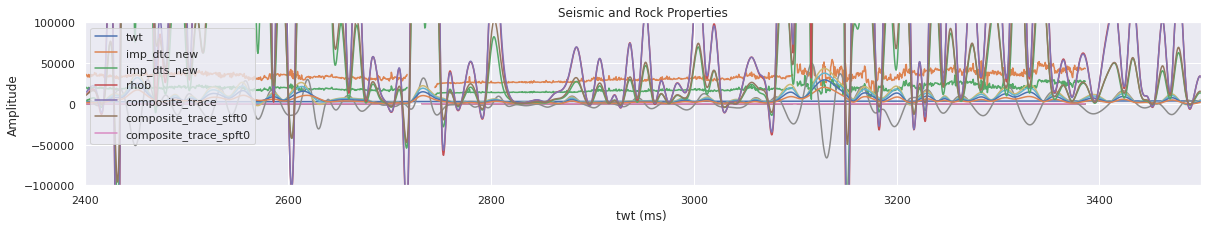

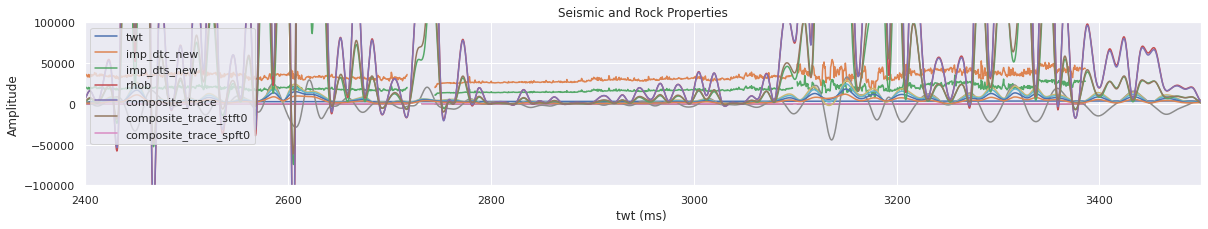

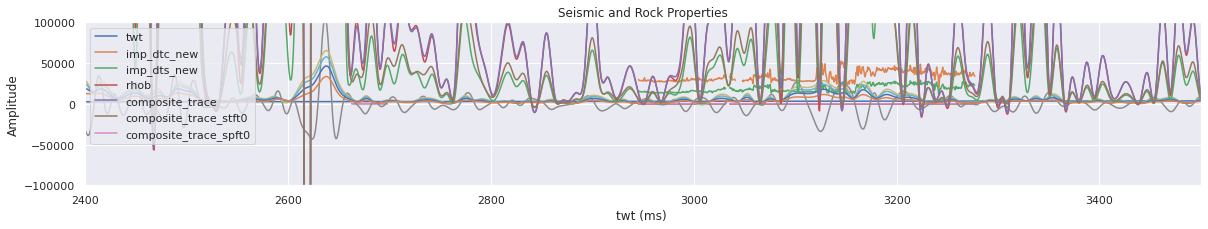

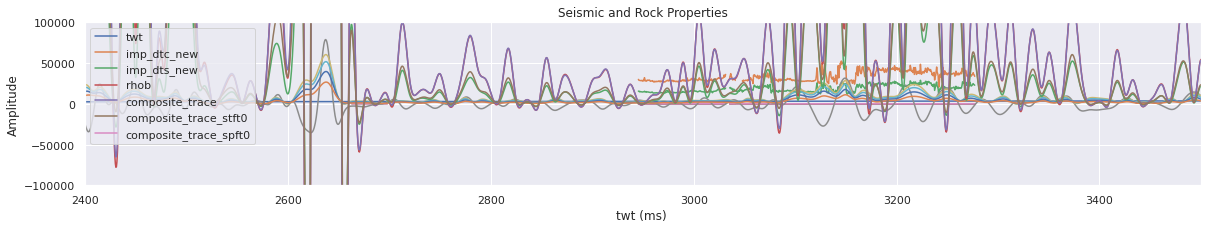

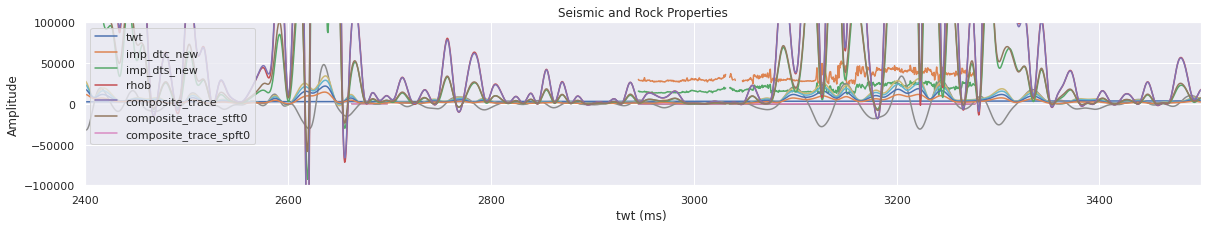

In [29]:
for tt_wells in tt_independent_wells:
    plt.figure(figsize=(20,3))
    plt.plot(np.arange(0,6000.5,.5), tt_wells[:])
    plt.title('Seismic and Rock Properties')
    plt.ylim(-100000,100000)
    plt.xlim(2400,3500)
    plt.xlabel('twt (ms) ')
    plt.ylabel('Amplitude')
    plt.legend(loc='upper left', labels =['twt','imp_dtc_new','imp_dts_new','rhob','composite_trace','composite_trace_stft0','composite_trace_spft0'])

In [30]:
tt_independent_wells_more = []
fs = 20e2
N = 1e5
nfft=2**14
nperseg=20
noverlap=5
#col1 = ['composite_trace_spft0', 'composite_trace_spft1','composite_trace_spft2', 'composite_trace_spft3']
#col2 = ['composite_trace_sfft0', 'composite_trace_sfft1','composite_trace_sfft2', 'composite_trace_sfft3']
for tt_well in tt_independent_wells:
    tt_well['composite_trace'] = tt_well['composite_trace'].fillna(0)
    tt_well['GradTrail5'] = tt_well['composite_trace'].diff(periods=-5)
    tt_well['GradLead5'] = tt_well['composite_trace'].diff(periods=5)
    tt_well['GradTrail10'] = tt_well['composite_trace'].diff(periods=-10)
    tt_well['GradLead10'] = tt_well['composite_trace'].diff(periods=10)
    tt_well['HTEnv'] = np.abs(hilbert(tt_well['composite_trace']))
    tt_well['HTEnvCosPhs'] = np.cos(np.angle(hilbert(tt_well['composite_trace']))) * tt_well['HTEnv']
    #tmp_new = tt_well['composite_trace'].fillna(0) #.fillna(tt_well['composite_trace'].mean)
    #df_spft_temp, df_stft_temp = get_specttime(tmp_new, fs, nperseg, nfft, noverlap, 'composite_trace')
    #for col in df_spft_temp.columns:
    #    tt_well[col+'_sp'] = df_spft_temp[col]
    #    
    #for col in df_stft_temp.columns:
    #    tt_well[col+'_st'] = df_stft_temp[col]
        
    #print(len(df_spft_temp), len(tmp_new))
    #tt_well[col1], tt_well[col2] =  get_specttime(tmp_new, fs, nperseg, nfft, noverlap, 'composite_trace')
    #tt_well = tt_well.merge(df_spft_temp, on='twt')
    #tt_well = tt_well.merge(df_stft_temp, on='twt')
    tt_well = tt_well[tt_well['twt']>2000]
    tt_independent_wells_more.append(tt_well)
    
print(tt_well.columns)
tt_well.head()
#tt_well.describe()


Index(['twt', 'imp_dtc_new', 'imp_dts_new', 'imp_dtc_new_log',
       'imp_dts_new_log', 'rhob_new', 'rhob_new_log', 'composite_trace',
       'composite_trace_stft0', 'composite_trace_stft1',
       'composite_trace_stft2', 'composite_trace_stft3',
       'composite_trace_spft0', 'composite_trace_spft1',
       'composite_trace_spft2', 'composite_trace_spft3', 'GradTrail5',
       'GradLead5', 'GradTrail10', 'GradLead10', 'HTEnv', 'HTEnvCosPhs'],
      dtype='object')


twt  imp_dtc_new  imp_dts_new  imp_dtc_new_log  imp_dts_new_log  \
well_name                                                                       
well_33    2000.5          NaN          NaN              NaN              NaN   
well_33    2001.0          NaN          NaN              NaN              NaN   
well_33    2001.5          NaN          NaN              NaN              NaN   
well_33    2002.0          NaN          NaN              NaN              NaN   
well_33    2002.5          NaN          NaN              NaN              NaN   

           rhob_new  rhob_new_log  composite_trace  composite_trace_stft0  \
well_name                                                                   
well_33         NaN           NaN    -28432.941436           21226.608720   
well_33         NaN           NaN    -28471.320403           21879.210526   
well_33         NaN           NaN    -28203.818949           22509.876601   
well_33         NaN           NaN    -27639.818942           23117.152974   
well_33         NaN           NaN    -26788.702249           23699.585677   

           composite_trace_stft1  ...  composite_trace_spft0  \
well_name                         ...                          
well_33             18102.863735  ...           39425.265164   
well_33             18644.336161  ...           38085.875896   
well_33             19165.290878  ...           38266.686198   
well_33             19664.472200  ...           39899.074871   
well_33             20140.624441  ...           42914.420715   

           composite_trace_spft1  composite_trace_spft2  \
well_name                                                 
well_33             80157.578750          106219.813367   
well_33             75402.610590          101926.875070   
well_33             74645.363599          101489.523188   
well_33             77706.623478          104734.348165   
well_33             84407.175926          111487.940447   

           composite_trace_spft3   GradTrail5    GradLead5   GradTrail10  \
well_name                                                                  
well_33             89947.237163 -2773.090697 -4578.504753 -12155.725791   
well_33             88920.987532 -4208.674125 -3214.758774 -14656.296461   
well_33             89420.091235 -5597.348214 -1748.870391 -16974.800132   
well_33             91374.835114 -6935.435952  -230.523518 -19089.174726   
well_33             94715.506010 -8204.552273  1290.597933 -20977.358160   

             GradLead10         HTEnv   HTEnvCosPhs  
well_name                                            
well_33   -13237.094861  28603.064696 -28432.941436  
well_33   -11456.722723  29050.819092 -28471.320403  
well_33    -9375.164728  29438.922347 -28203.818949  
well_33    -7039.638008  29775.302159 -27639.818942  
well_33    -4499.826480  30065.557146 -26788.702249  

[5 rows x 22 columns]

In [31]:
tt_independent_wells_more[0].columns

Index(['twt', 'imp_dtc_new', 'imp_dts_new', 'imp_dtc_new_log',
       'imp_dts_new_log', 'rhob_new', 'rhob_new_log', 'composite_trace',
       'composite_trace_stft0', 'composite_trace_stft1',
       'composite_trace_stft2', 'composite_trace_stft3',
       'composite_trace_spft0', 'composite_trace_spft1',
       'composite_trace_spft2', 'composite_trace_spft3', 'GradTrail5',
       'GradLead5', 'GradTrail10', 'GradLead10', 'HTEnv', 'HTEnvCosPhs'],
      dtype='object')

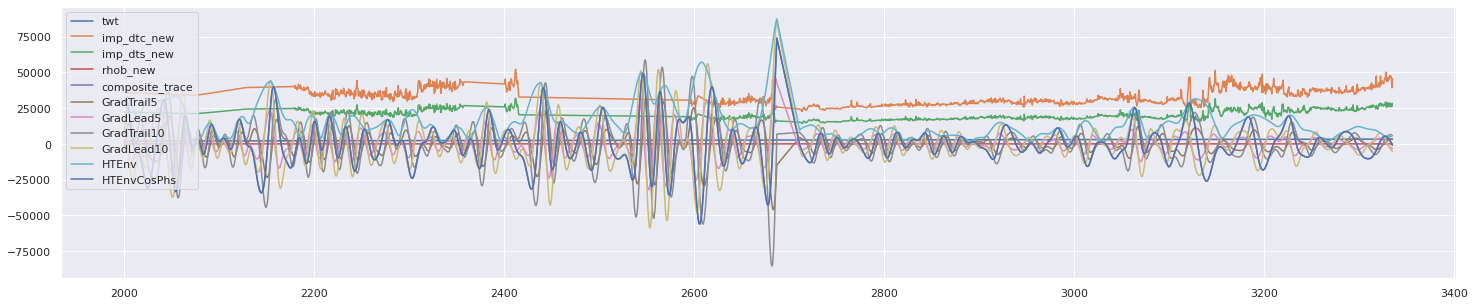

In [32]:
check = tt_independent_wells_more[0].reset_index()
check = check.dropna()
plt.figure(figsize=(25,5))
plt.plot(check['twt'], check[['twt', 
                              'imp_dtc_new', 'imp_dts_new', 'rhob_new',
                              'composite_trace',
                              'GradTrail5', 'GradLead5', 'GradTrail10', 'GradLead10',
                              'HTEnv', 'HTEnvCosPhs']])

plt.legend(loc='upper left', labels =['twt', 
                                      'imp_dtc_new', 'imp_dts_new', 'rhob_new',
                                      'composite_trace',
                                      'GradTrail5', 'GradLead5', 'GradTrail10', 'GradLead10',
                                      'HTEnv', 'HTEnvCosPhs']);


We will be doing the final evaluation on completely different set of wells (2 wells).

In [33]:
training_wells = tt_independent_wells_more[:5]
testing_well = tt_independent_wells_more[5]

We will now concatenate all of the wells in the training dataset and seperate into X_train (inputs) and y_train (targets) & X_test (inputs) and y_test (targets). We will also shuffle the data because the keras fit functions will take a percentage from the bottom of the dataset and reserve it for validation. If we don't shuffle, then we will only be validating on data from the last well in the dataframe.  

In [34]:
features = ['twt','composite_trace','GradTrail5','GradLead5','GradTrail10','GradLead10','HTEnv', 'HTEnvCosPhs',
       'composite_trace_stft0', 'composite_trace_stft1',
       'composite_trace_stft2', 'composite_trace_stft3',
       'composite_trace_spft0', 'composite_trace_spft1',
       'composite_trace_spft2', 'composite_trace_spft3']
targets = ['imp_dtc_new', 'imp_dts_new', 'rhob_new']

# Here we concat all of the training wells and drop rows with nans
training_wells_tt = pd.concat(training_wells)
training_wells_tt = training_wells_tt.dropna()

# Here we shuffle the data
training_wells_tt = training_wells_tt.sample(frac=1)

# Here we seperate into inputs and targets 
X_train = training_wells_tt[features]
y_train = training_wells_tt[targets]

# Print for QC
print('training inputs:', X_train)
print('training targets:',y_train)

# Here we drop rows with nans in testing data
testing_well_tt = testing_well
testing_well_tt = testing_well_tt.dropna()

# Here we seperate into inputs and targets 
X_test = testing_well_tt[features]
y_test = testing_well_tt[targets]

# Print for QC
print('testing inputs:', X_test)
print('testing targets:',y_test)

training inputs:               twt  composite_trace   GradTrail5     GradLead5   GradTrail10  \
well_name                                                                     
well_11    3423.5     -6087.188685  1053.405147  -2956.180154   -743.002395   
well_11    3020.5      2804.730352  1515.571179   -756.853845   3508.237547   
well_01    3196.5    -15825.513150  2381.088802  -6480.405091    984.656291   
well_01    2157.0     39390.075435  3192.649928  12673.138191  17814.986850   
well_11    2796.5        47.096442  -418.721318    805.346835   -367.308390   
...           ...              ...          ...           ...           ...   
well_01    2990.5       219.345944  2427.142533  -4628.861826   1825.088380   
well_01    3122.0     13862.417311  2990.401433  -1199.612206   7473.870535   
well_01    2588.5     14881.508409 -1145.076950  -1955.828234  -3770.887419   
well_11    3146.5      3526.104266   964.553447   -807.797594   1746.916351   
well_11    2521.5     -8780.835378 

### Data Preparation for ML Model Training

### Normalize that data

Let's create a simple function to help us with this. This function returns two things: the scaled dataset (scaled_data) and the scaler for using to inverse transfomr the data (scaler)

In [35]:
def minmax_scaler(data, minmaxrange=(-1,1)):
    scaler = MinMaxScaler(feature_range = minmaxrange)
    scaled_data = scaler.fit_transform(data)
    return scaled_data, scaler

def SS_scaler(data, minmaxrange=(-1,1)):
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data)
    return scaled_data, scaler

In [36]:
# Here we scale the training inputs and create the scaler to be used to scale testing data and for inverse transform after simulation
#X_train_scaled, X_scaler = minmax_scaler(X_train, minmaxrange=(-1,1))
X_train_scaled, X_scaler = SS_scaler(X_train, minmaxrange=(-1,1))
X_test_scaled = X_scaler.transform(X_test)

# Scaling converts dataframes to numpy arrays automatically so we want to convert back to pandas dataframe
X_train_scaled = pd.DataFrame(X_train_scaled, index=X_train.index, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, index=X_test.index, columns=X_test.columns)

# Here we do the same for the targets
#y_train_scaled, y_scaler = minmax_scaler(y_train, minmaxrange=(-1,1))
y_train_scaled, y_scaler = SS_scaler(y_train, minmaxrange=(-1,1))
y_test_scaled = y_scaler.transform(y_test)

# Scaling converts dataframes to numpy arrays automatically so we want to convert back to pandas dataframe
y_train_scaled = pd.DataFrame(y_train_scaled, index=y_train.index, columns=y_train.columns)
y_test_scaled = pd.DataFrame(y_test_scaled, index=y_test.index, columns=y_test.columns)

In [37]:
X_train_scaled.head(5)

twt  composite_trace  GradTrail5  GradLead5  GradTrail10  \
well_name                                                                  
well_11    1.735726        -0.523988    0.182729  -0.499700    -0.058631   
well_11    0.677212         0.262676    0.259704  -0.131476     0.316806   
well_01    1.139491        -1.385533    0.403859  -1.089747     0.093943   
well_01   -1.590845         3.499365    0.539026   2.117054     1.580270   
well_11    0.088857         0.018709   -0.062457   0.130077    -0.025453   

           GradLead10     HTEnv  HTEnvCosPhs  composite_trace_stft0  \
well_name                                                             
well_11     -0.506483 -0.413722    -0.523988              -0.498393   
well_11     -0.053767 -0.648007     0.262676              -0.750933   
well_01     -1.406406  0.666030    -1.385533               1.232591   
well_01      3.179170  2.752590     3.499365               3.756108   
well_11      0.161472 -0.895102     0.018709              -0.908779   

           composite_trace_stft1  composite_trace_stft2  \
well_name                                                 
well_11                -0.504684              -0.504118   
well_11                -0.770566              -0.785888   
well_01                 1.176704               1.091177   
well_01                 3.739576               3.677282   
well_11                -0.945582              -0.985945   

           composite_trace_stft3  composite_trace_spft0  \
well_name                                                 
well_11                -0.491421              -0.376296   
well_11                -0.791484              -0.362951   
well_01                 0.965497               0.139645   
well_01                 3.546978               0.224514   
well_11                -1.014485              -0.371095   

           composite_trace_spft1  composite_trace_spft2  composite_trace_spft3  
well_name                                                                       
well_11                -0.373221              -0.372982              -0.370782  
well_11                -0.357155              -0.360942              -0.372043  
well_01                 0.131522               0.115415               0.073030  
well_01                 0.130123               0.265590               0.706099  
well_11                -0.366072              -0.370257              -0.382134

### Neural Network Model Training

The model below is a Sequential Model: A Sequential model is appropriate for a plain stack of layers where each layer has exactly one input tensor and one output tensor. Learn more about Sequential Models here: https://keras.io/guides/sequential_model/

**Architecture:**
- 8 input Neurons 
- 2 Hidden Layers w/ 32 neurons each 
- 3 Outputs 

**Hyperparameters:**
- Hidden Layer has ReLu Activation
- Output Layer has Linear Activation
- Adam Optimizer
- MSE as loss metric 
- EarlyStopping is active w/ Patience = 30 
- Batch Size is 256 
- 50% of data is reserved for validation 
- Training with a MAX of 5000 Epochs

In [38]:
# %%time
# Train models and keep them in memory 
# This is where we define the amount of models in the ensemble
# We save those models to a list 'models'
n_members = 5
model_store = []

# We store our training performance in 'history_store'
history_store = []

accuracy_store = []
#here we define model architecture and train the neural network in a loop for each model 
for i in range(n_members): 
    model = Sequential()
    
    # Adding layers
    model.add(layers.Dense(32, activation='relu', input_dim=X_train_scaled.shape[1], kernel_initializer='he_uniform'))
    model.add(layers.Dense(32, activation='relu', kernel_initializer='he_uniform'))
    model.add(layers.Dense(y_train_scaled.shape[1], activation='linear'))
    
    # Setting optimizer
    opt = keras.optimizers.Adam(learning_rate=0.001)
    
    # Compile model and add callbacks
    model.compile(optimizer=opt, loss='mse')
    callbacks = [k.callbacks.EarlyStopping(monitor='loss', patience=30)]
    
    # Fit and save! 
    history_store.append(model.fit(X_train_scaled, 
                                   y_train_scaled, 
                                   epochs=5000, validation_split=0.5,
                                   shuffle=True, batch_size=256, callbacks=callbacks,
                                   verbose=0))
    accuracy = model.evaluate(X_train_scaled, y_train_scaled)
    accuracy_store.append(accuracy)
    
    model_store.append(model)
    
    # Some basic print statements for updating us during training
    loss = history_store[i].history['loss']
    epochs = range(len(loss))
    print('-------------------------------------------------- Completed Training of Model #', i)
    print('-------------------------------------------------- Total Epochs Range:', epochs )
    print('-----------------------------------------------------------------------------------')

11550/11550 [==============================] - 0s 40us/sample - loss: 0.2316
-------------------------------------------------- Completed Training of Model # 0
-------------------------------------------------- Total Epochs Range: range(0, 1911)
-----------------------------------------------------------------------------------
11550/11550 [==============================] - 1s 53us/sample - loss: 0.2494
-------------------------------------------------- Completed Training of Model # 1
-------------------------------------------------- Total Epochs Range: range(0, 856)
-----------------------------------------------------------------------------------
11550/11550 [==============================] - 1s 61us/sample - loss: 0.2379
-------------------------------------------------- Completed Training of Model # 2
-------------------------------------------------- Total Epochs Range: range(0, 1152)
-----------------------------------------------------------------------------------
11550/11550

Visualize the training metrics - loss and validation loss functions

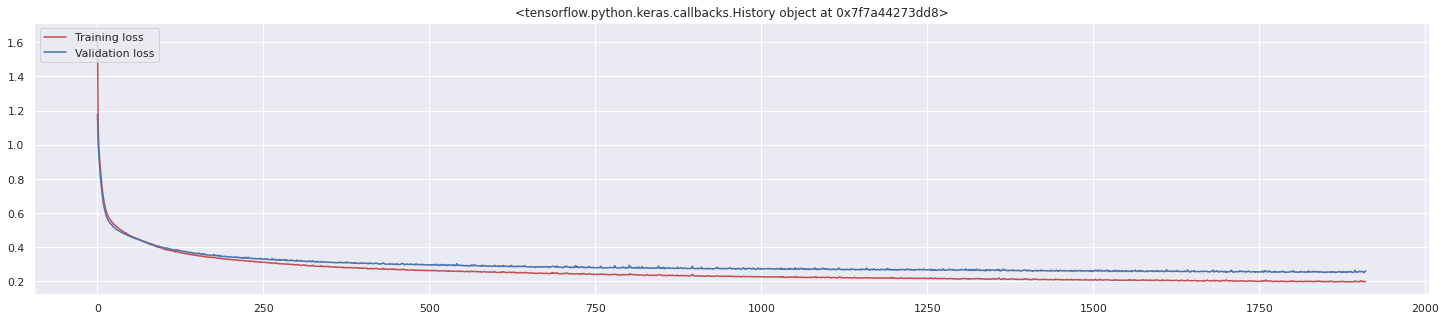

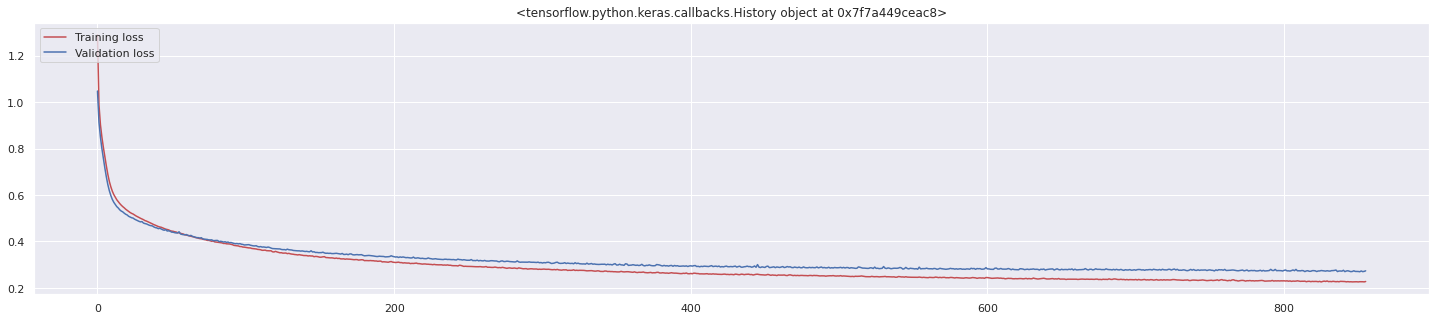

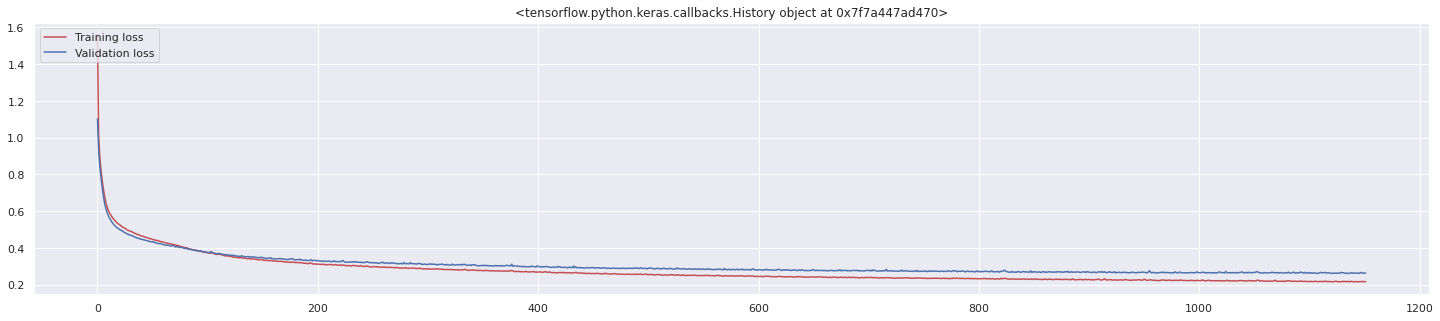

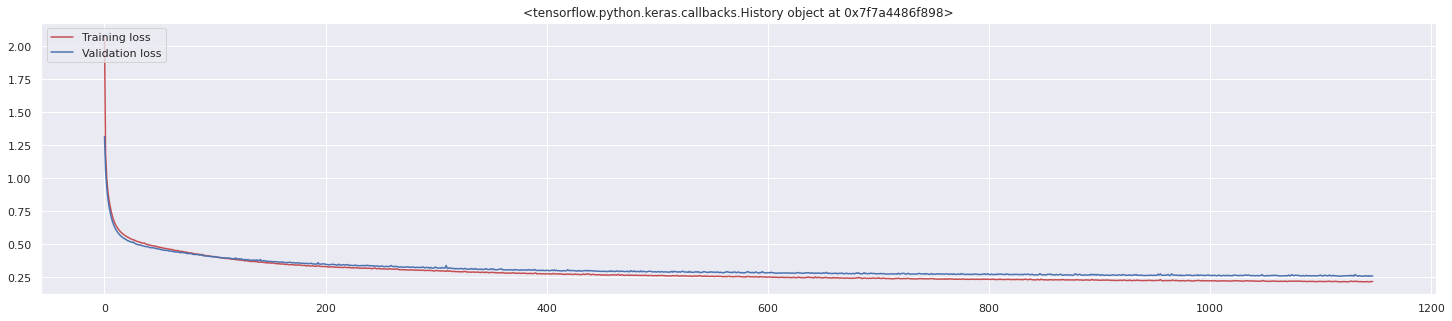

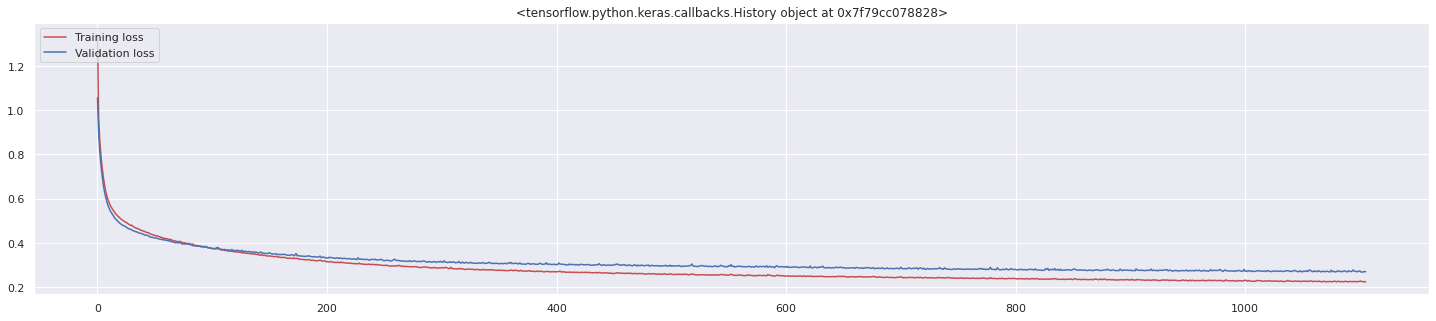

In [39]:
for history in history_store:
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(loss))
    plt.figure(figsize=(25,5))
    plt.plot(epochs, loss, 'r', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.legend(loc='upper left')
    plt.title(str(history))

## Bootstrap Aggregation and Inference

In [40]:
yhats = [y_scaler.inverse_transform(model.predict(X_test_scaled)) for model in model_store]
yhats = np.array(yhats)

Zp_ensemble = yhats[:,:,0].mean(0)
Zs_ensemble = yhats[:,:,1].mean(0)
Rhob_ensemble = yhats[:,:,2].mean(0)

Results = y_test.copy()
Results['Zp_Prediction'] = Zp_ensemble
Results['Zs_Prediction'] = Zs_ensemble
Results['Rhob_Prediction'] = Rhob_ensemble
Results['twt'] = X_test['twt']
Results = Results.reset_index()
Results.head()

well_name   imp_dtc_new   imp_dts_new  rhob_new  Zp_Prediction  \
0   well_11  29855.962736  15013.235544  2.597872   31642.964844   
1   well_11  29855.962736  15013.235544  2.597872   31664.136719   
2   well_11  29855.962736  15013.235544  2.597872   31543.589844   
3   well_11  29855.962736  15013.235544  2.597872   31448.308594   
4   well_11  29855.962736  15013.235544  2.597872   31414.099609   

   Zs_Prediction  Rhob_Prediction     twt  
0   17981.656250         2.562938  2507.0  
1   17981.068359         2.562459  2507.5  
2   17870.867188         2.560783  2508.0  
3   17777.261719         2.559997  2508.5  
4   17727.050781         2.559957  2509.0

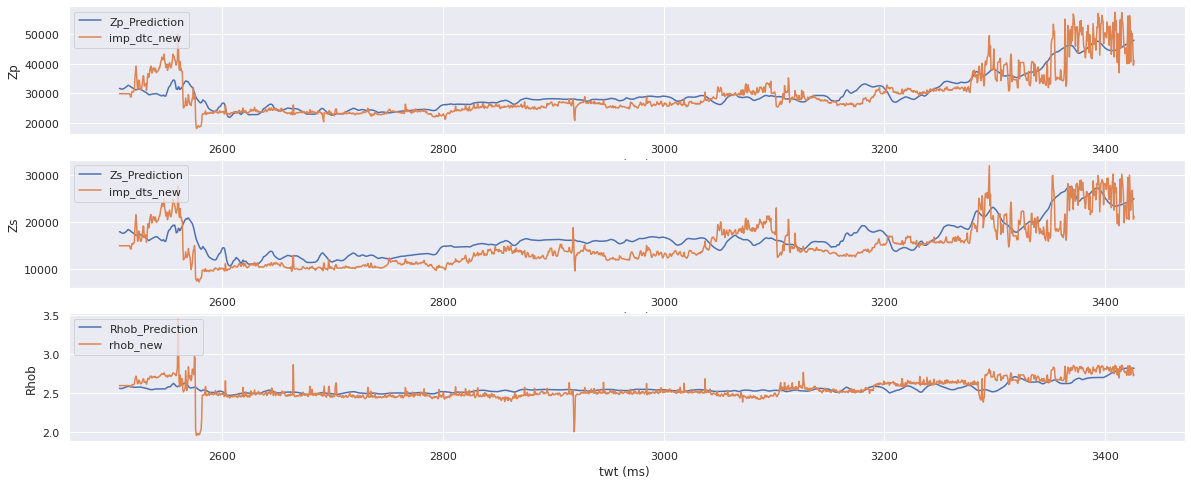

In [41]:
plt.figure(figsize=(20,8))
plt.subplot(311)
plt.plot(Results['twt'],Results[['Zp_Prediction','imp_dtc_new']])
plt.legend(loc='upper left', labels =['Zp_Prediction','imp_dtc_new'])
plt.xlabel('twt (ms) ')
plt.ylabel('Zp')
plt.subplot(312)
plt.plot(Results['twt'],Results[['Zs_Prediction','imp_dts_new']])
plt.legend(loc='upper left', labels =['Zs_Prediction','imp_dts_new'])
plt.xlabel('twt (ms) ')
plt.ylabel('Zs')
plt.subplot(313)
plt.plot(Results['twt'],Results[['Rhob_Prediction','rhob_new']])
plt.legend(loc='upper left', labels =['Rhob_Prediction','rhob_new'])
plt.xlabel('twt (ms) ')
plt.ylabel('Rhob')
plt.show();

In [42]:
## evaluate the keras model
for accuracy in accuracy_store:
    print('Accuracy: %.2f' % (accuracy*100))

Accuracy: 23.16
Accuracy: 24.94
Accuracy: 23.79
Accuracy: 23.64
Accuracy: 24.62


NRSME for Zp: 0.11839310447337001
NRSME for Zs: 0.2023034702250114
NRSME for Rhob: 0.03510979533130805


(2.0, 3.2)

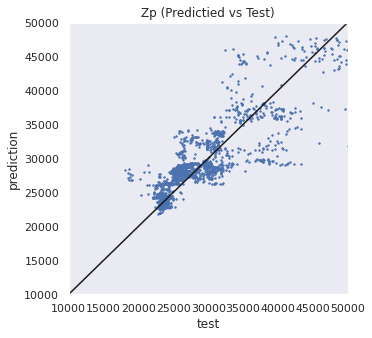

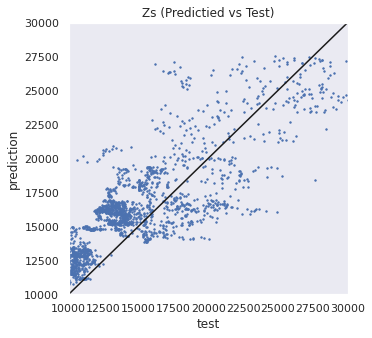

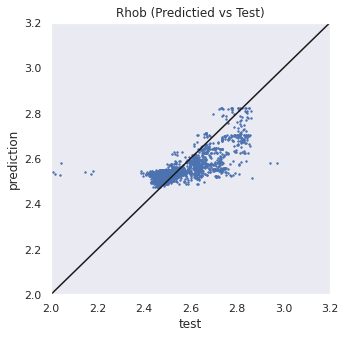

In [43]:
nrmse = {}

nrmse['Zp'] = np.sqrt(mean_squared_error(Results['imp_dtc_new'], Results['Zp_Prediction'])) / np.mean(Results['imp_dtc_new'])
nrmse['Zs'] = np.sqrt(mean_squared_error(Results['imp_dts_new'], Results['Zs_Prediction'])) / np.mean(Results['imp_dts_new'])
nrmse['Rhob'] = np.sqrt(mean_squared_error(Results['rhob_new'], Results['Rhob_Prediction'])) / np.mean(Results['rhob_new'])

### Compute score and loss and compare against test data
print("NRSME for Zp: {}".format(nrmse['Zp']))
print("NRSME for Zs: {}".format(nrmse['Zs']))
print("NRSME for Rhob: {}".format(nrmse['Rhob']))

plt.figure(figsize=(5,5))
plt.plot(np.linspace(10000,50000,10),np.linspace(10000,50000,10),'-k')
plt.scatter(Results['imp_dtc_new'], Results['Zp_Prediction'], s=2)
plt.xlabel('test');plt.ylabel('prediction'),plt.title('Zp (Predictied vs Test)')
plt.grid(); plt.xlim(10000,50000);plt.ylim(10000,50000)


plt.figure(figsize=(5,5))
plt.plot(np.linspace(10000,30000,10),np.linspace(10000,30000,10),'-k')
plt.scatter(Results['imp_dts_new'], Results['Zs_Prediction'], s=2)
plt.xlabel('test');plt.ylabel('prediction'),plt.title('Zs (Predictied vs Test)')
plt.grid(); plt.xlim(10000,30000);plt.ylim(10000,30000)


plt.figure(figsize=(5,5))
plt.plot(np.linspace(2,3.2,10),np.linspace(2,3.2,10),'-k')
plt.scatter(Results['rhob_new'], Results['Rhob_Prediction'], s=2)
plt.xlabel('test');plt.ylabel('prediction'),plt.title('Rhob (Predictied vs Test)')
plt.grid(); plt.xlim(2,3.2);plt.ylim(2,3.2)

### GBR!!

In [44]:
### Plot training history
def deviance(reg, X_test, y_test, plot=False):
    test_score = np.zeros((reg.n_estimators,), dtype=np.float64)
    for i, y_pred in enumerate(reg.staged_predict(X_test)):
        test_score[i] = reg.loss_(y_test, y_pred)

    if plot == True:
        fig = plt.figure(figsize=(5, 5))
        plt.subplot(1, 1, 1)
        plt.title('Deviance')
        plt.plot(np.arange(reg.n_estimators) + 1, reg.train_score_, 'b-',label='Training loss')
        plt.plot(np.arange(reg.n_estimators) + 1, test_score, 'r-',label='Test loss')
        plt.xlabel('Boosting Iterations')
        plt.ylabel('Loss')
        plt.legend(loc='upper right'); plt.grid()
    else:
        return test_score
    
    

## Train a gradient boosting model

In [45]:
params = {'loss': 'ls',
          'learning_rate': 0.03,
          'n_estimators': 200,
          'subsample': 0.8,
          'max_depth': 64,
          'max_features': 0.3,
          'min_impurity_decrease': 1e-10,
          'min_samples_leaf': 5
         }

print('Training...')
reg = gbr(random_state=98,**params)
reg.fit(X_train_scaled, y_train_scaled)

y_pred = reg.predict(X_test_scaled)

yhats = y_scaler.inverse_transform(y_pred)
yhats = np.array(yhats)

Training...


ValueError: y should be a 1d array, got an array of shape (11550, 3) instead.

# Todo ?
Change model architecture?
learning rate?
shuffle or not shuffle?
gbr?
